Cell 1: Data loading and processing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

# Set publication style with SciencePlots
plt.style.use(['science', 'no-latex', 'bright'])
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300
})

# Load data
workbook = "All Workshop Analysis .xlsx"
sheets = {
    "Emergency Medicine": "EM_Analysis",
    "Orthopedics": "Ortho_Analysis",
    "PM&R": "PMR_Analysis",
    "General Surgery": "GenSurg_Analysis"
}

workshop_dates = {
    "PM&R": pd.Timestamp("2024-04-01"),
    "Orthopedics": pd.Timestamp("2024-09-01"),
    "Emergency Medicine": pd.Timestamp("2024-10-01"),
    "General Surgery": pd.Timestamp("2024-11-01")
}

# Process data
retention_data = []
sig_info = {}

for workshop, sheet in sheets.items():
    df = pd.read_excel(workbook, sheet_name=sheet, index_col=0)
    
    mean_post = pd.to_numeric(df.loc["mean_post"], errors='coerce').mean()
    mean_fu = pd.to_numeric(df.loc["Mean_fu"], errors='coerce').mean()
    
    # Check significance
    sig_change = False
    try:
        stat_sig_row = df.loc["Stat Sig"]
        yes_count = (stat_sig_row.str.upper() == "YES").sum()
        total_count = stat_sig_row.notna().sum()
        sig_change = (yes_count / total_count) >= 0.5 if total_count > 0 else False
    except:
        try:
            p_vals = pd.to_numeric(df.loc["p-value"], errors="coerce").dropna()
            sig_change = (p_vals < 0.05).sum() >= (len(p_vals) * 0.5)
        except:
            sig_change = False
    
    retention_data.extend([
        {"Workshop": workshop, "Date": workshop_dates[workshop], "Score": mean_post},
        {"Workshop": workshop, "Date": pd.Timestamp("2025-03-01"), "Score": mean_fu}
    ])
    
    sig_info[workshop] = {
        "significant": sig_change,
        "direction": "up" if mean_fu > mean_post else "down"
    }

retention_df = pd.DataFrame(retention_data)

Cell 2: Figure 1 - Retention Line Plot

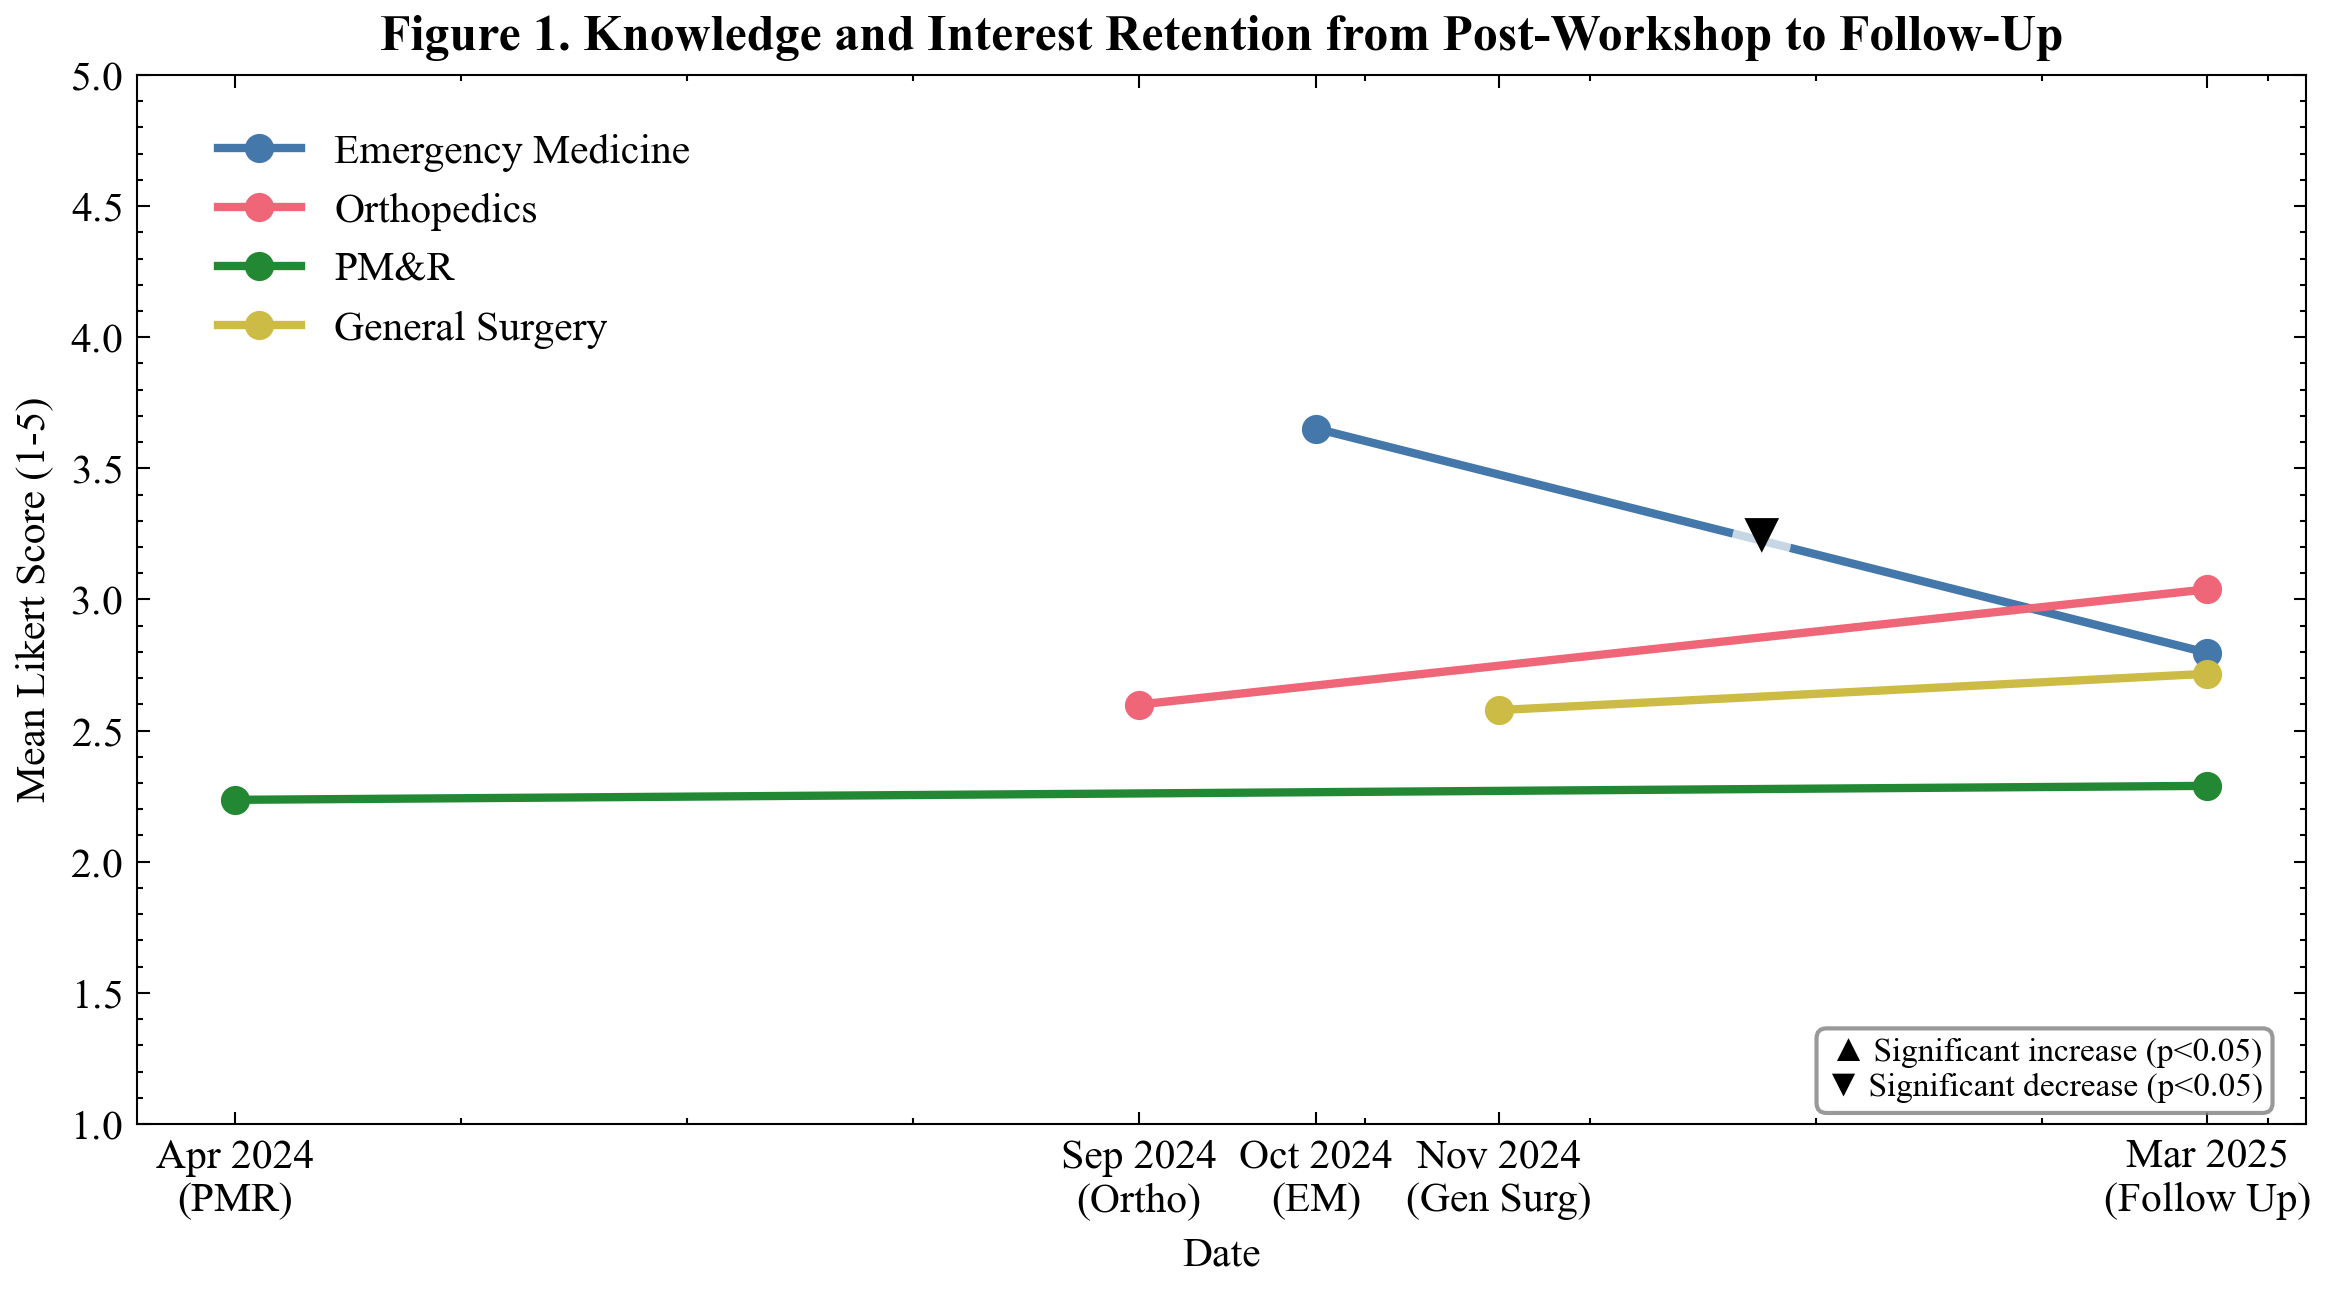

In [2]:
plt.figure(figsize=(8, 4.5))
ax = plt.gca()

# Create line plot
for workshop in sig_info.keys():
    workshop_data = retention_df[retention_df["Workshop"] == workshop]
    ax.plot(workshop_data["Date"], workshop_data["Score"], 
            marker='o', markersize=6, linewidth=2, label=workshop)

ax.set_xlabel("Date")
ax.set_ylabel("Mean Likert Score (1-5)")
ax.set_title("Figure 1. Knowledge and Interest Retention from Post-Workshop to Follow-Up", 
             fontweight='bold')
ax.set_ylim(1, 5)

# Format x-axis with more spacing
unique_dates = sorted(retention_df["Date"].unique())
ax.set_xticks(unique_dates)
labels = ["Apr 2024\n(PMR)", "Sep 2024\n(Ortho)", "Oct 2024\n(EM)", 
          "Nov 2024\n(Gen Surg)", "Mar 2025\n(Follow Up)"]
ax.set_xticklabels(labels)
ax.margins(x=0.05)

# Add significance arrows in the middle of lines
for i, (workshop, info) in enumerate(sig_info.items()):
    if info["significant"]:
        workshop_data = retention_df[retention_df["Workshop"] == workshop]
        post_date = workshop_data.iloc[0]["Date"]
        fu_date = workshop_data.iloc[1]["Date"]
        post_score = workshop_data.iloc[0]["Score"]
        fu_score = workshop_data.iloc[1]["Score"]
        
        # Calculate midpoint
        mid_date = post_date + (fu_date - post_date) / 2
        mid_score = (post_score + fu_score) / 2
        
        # Draw arrow at midpoint
        if info["direction"] == "up":
            ax.annotate("▲", xy=(mid_date, mid_score),
                       color='black', fontsize=12, ha='center', va='center', 
                       weight='bold', bbox=dict(boxstyle="circle,pad=0.1", 
                       facecolor="white", edgecolor="none", alpha=0.7))
        else:
            ax.annotate("▼", xy=(mid_date, mid_score),
                       color='black', fontsize=12, ha='center', va='center',
                       weight='bold', bbox=dict(boxstyle="circle,pad=0.1", 
                       facecolor="white", edgecolor="none", alpha=0.7))

# Legend
ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
ax.text(0.98, 0.02, "▲ Significant increase (p<0.05)\n▼ Significant decrease (p<0.05)", 
        transform=ax.transAxes, fontsize=8, ha='right', va='bottom',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

plt.tight_layout()
plt.savefig("Manuscript/Fig1_retention_line.png", bbox_inches="tight")
plt.show()

Cell 3: Figure 2 - Engagement Methods

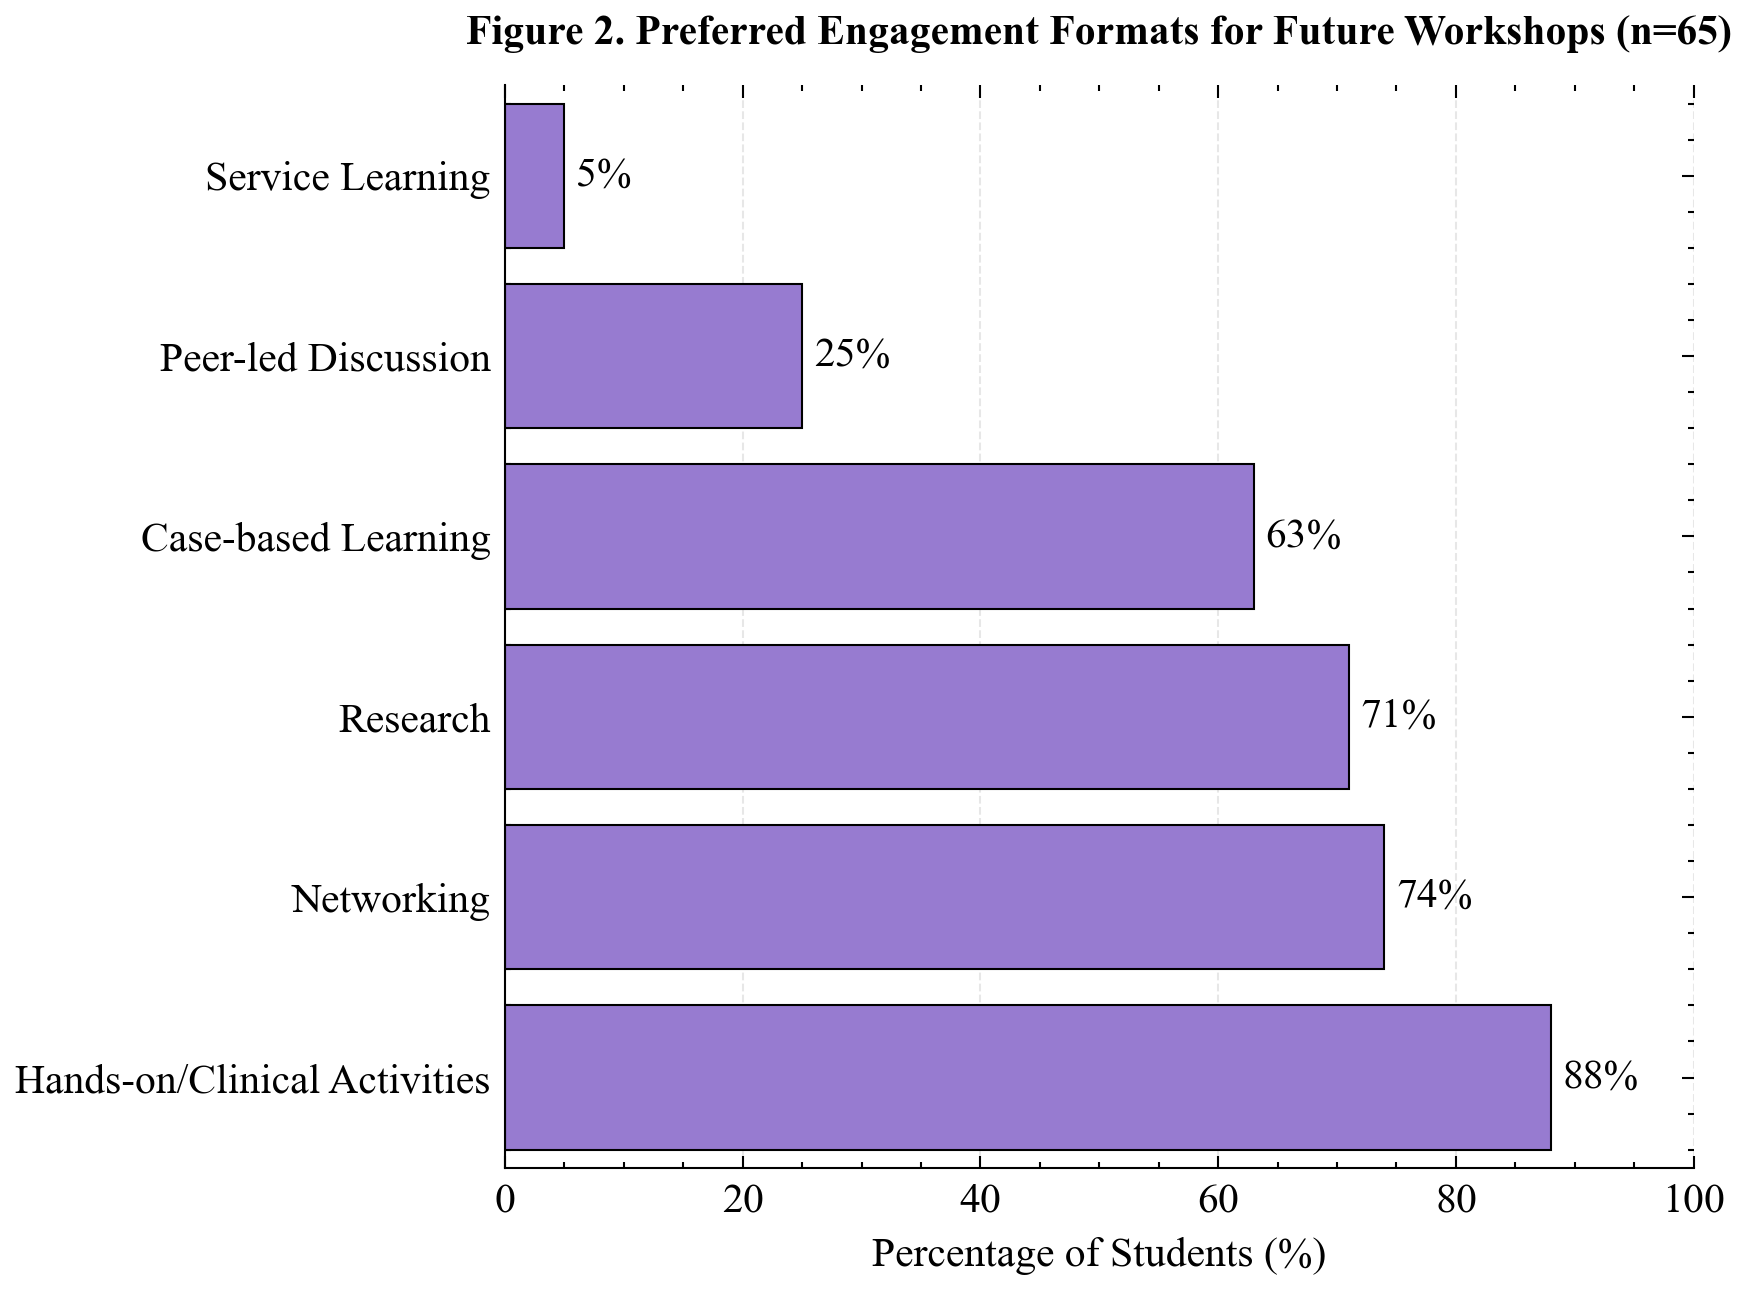

In [3]:
# Define engagement data
engagement_data = {
    "Hands-on/Clinical Activities": 57,
    "Networking": 48,
    "Research": 46,
    "Case-based Learning": 41,
    "Peer-led Discussion": 16,
    "Service Learning": 3
}

# Create DataFrame
engagement_df = pd.DataFrame([
    {"Method": method, "Percentage": round((count/65)*100)} 
    for method, count in engagement_data.items()
])
engagement_df = engagement_df.sort_values("Percentage", ascending=True)

# Create professional figure
fig, ax = plt.subplots(figsize=(6, 4.5))

# Create horizontal bar plot with purple color from mean post-workshop
sns.barplot(
    data=engagement_df,
    y="Method",
    x="Percentage",
    ax=ax,
    color="#9370DB",  # Purple color matching mean post-workshop
    saturation=0.8,
    edgecolor="black",
    linewidth=0.5
)

# Professional formatting
ax.set_xlabel("Percentage of Students (%)", fontsize=10)
ax.set_ylabel("", fontsize=10)
ax.set_title("Figure 2. Preferred Engagement Formats for Future Workshops (n=65)", 
             fontsize=10, fontweight='bold', pad=10)
ax.tick_params(axis='both', labelsize=10)

# Set x-axis limits
ax.set_xlim(0, 100)

# Add value labels
for i, (idx, row) in enumerate(engagement_df.iterrows()):
    ax.text(row['Percentage'] + 1, i, f"{int(row['Percentage'])}%", 
            va='center', fontsize=10)

# Remove top and right spines
sns.despine()

# Grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Save with tight layout
plt.tight_layout()
plt.savefig("Manuscript/Fig2_engagement.png", dpi=300, bbox_inches="tight")
plt.show()

Cell 4: Figure 3 - Mentorship Preferences

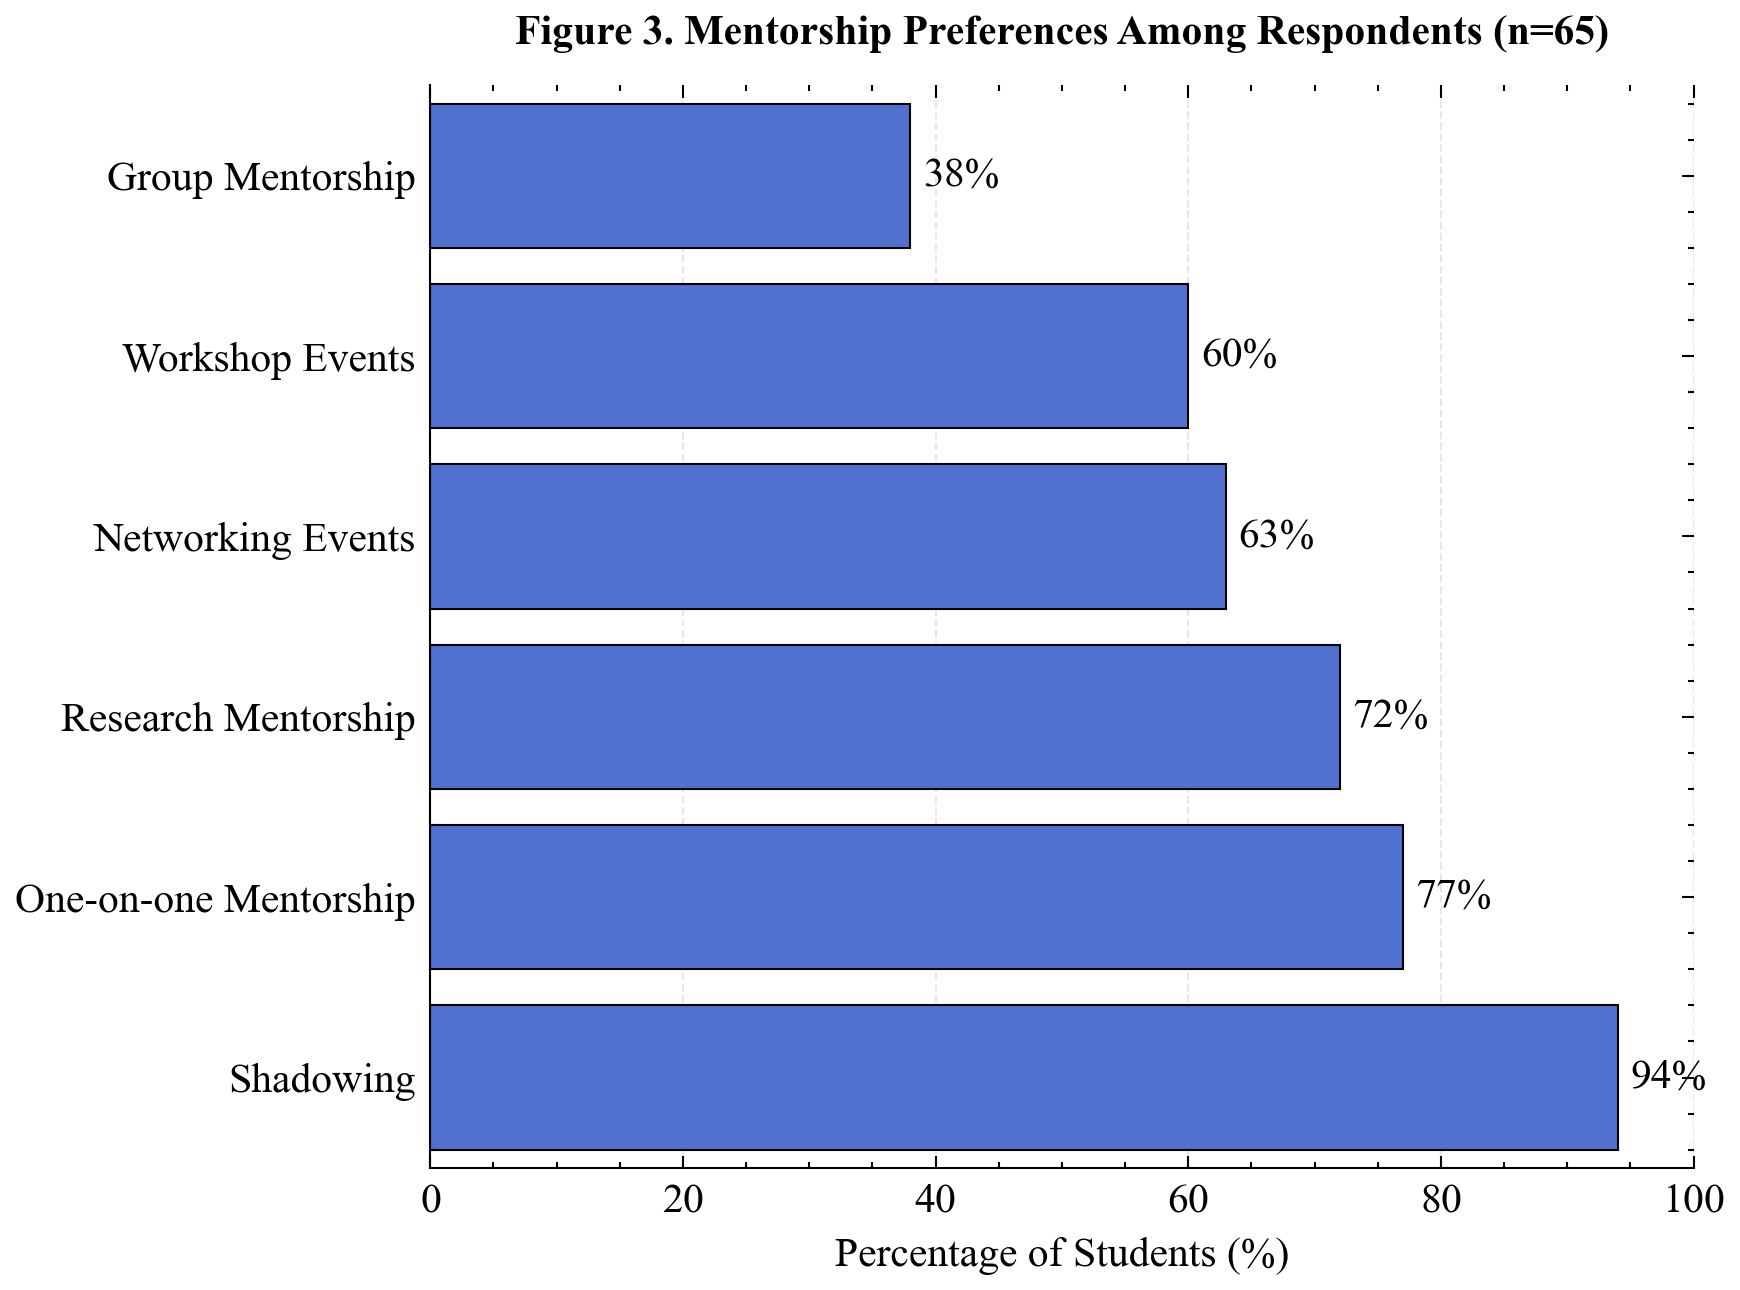

In [4]:
# Define mentorship data
mentorship_data = {
    "Shadowing": 61,
    "One-on-one Mentorship": 50,
    "Research Mentorship": 47,
    "Networking Events": 41,
    "Workshop Events": 39,
    "Group Mentorship": 25
}

# Create DataFrame
mentorship_df = pd.DataFrame([
    {"Format": format_name, "Percentage": round((count/65)*100)}
    for format_name, count in mentorship_data.items()
])
mentorship_df = mentorship_df.sort_values("Percentage", ascending=True)

# Create professional figure
fig, ax = plt.subplots(figsize=(6, 4.5))

# Create horizontal bar plot with blue color from mean 3-month follow-up
sns.barplot(
    data=mentorship_df,
    y="Format",
    x="Percentage",
    ax=ax,
    color="#4169E1",  # Blue color matching mean 3-month follow-up
    saturation=0.8,
    edgecolor="black",
    linewidth=0.5
)

# Professional formatting
ax.set_xlabel("Percentage of Students (%)", fontsize=10)
ax.set_ylabel("", fontsize=10)
ax.set_title("Figure 3. Mentorship Preferences Among Respondents (n=65)", 
             fontsize=10, fontweight='bold', pad=10)
ax.tick_params(axis='both', labelsize=10)

# Set x-axis limits
ax.set_xlim(0, 100)

# Add value labels
for i, (idx, row) in enumerate(mentorship_df.iterrows()):
    ax.text(row['Percentage'] + 1, i, f"{int(row['Percentage'])}%", 
            va='center', fontsize=10)

# Remove top and right spines
sns.despine()

# Grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Save with tight layout
plt.tight_layout()
plt.savefig("Manuscript/Fig3_mentorship.png", dpi=300, bbox_inches="tight")
plt.show()

Cell 5: Figure 1 (Bar Graph instead of line plots)

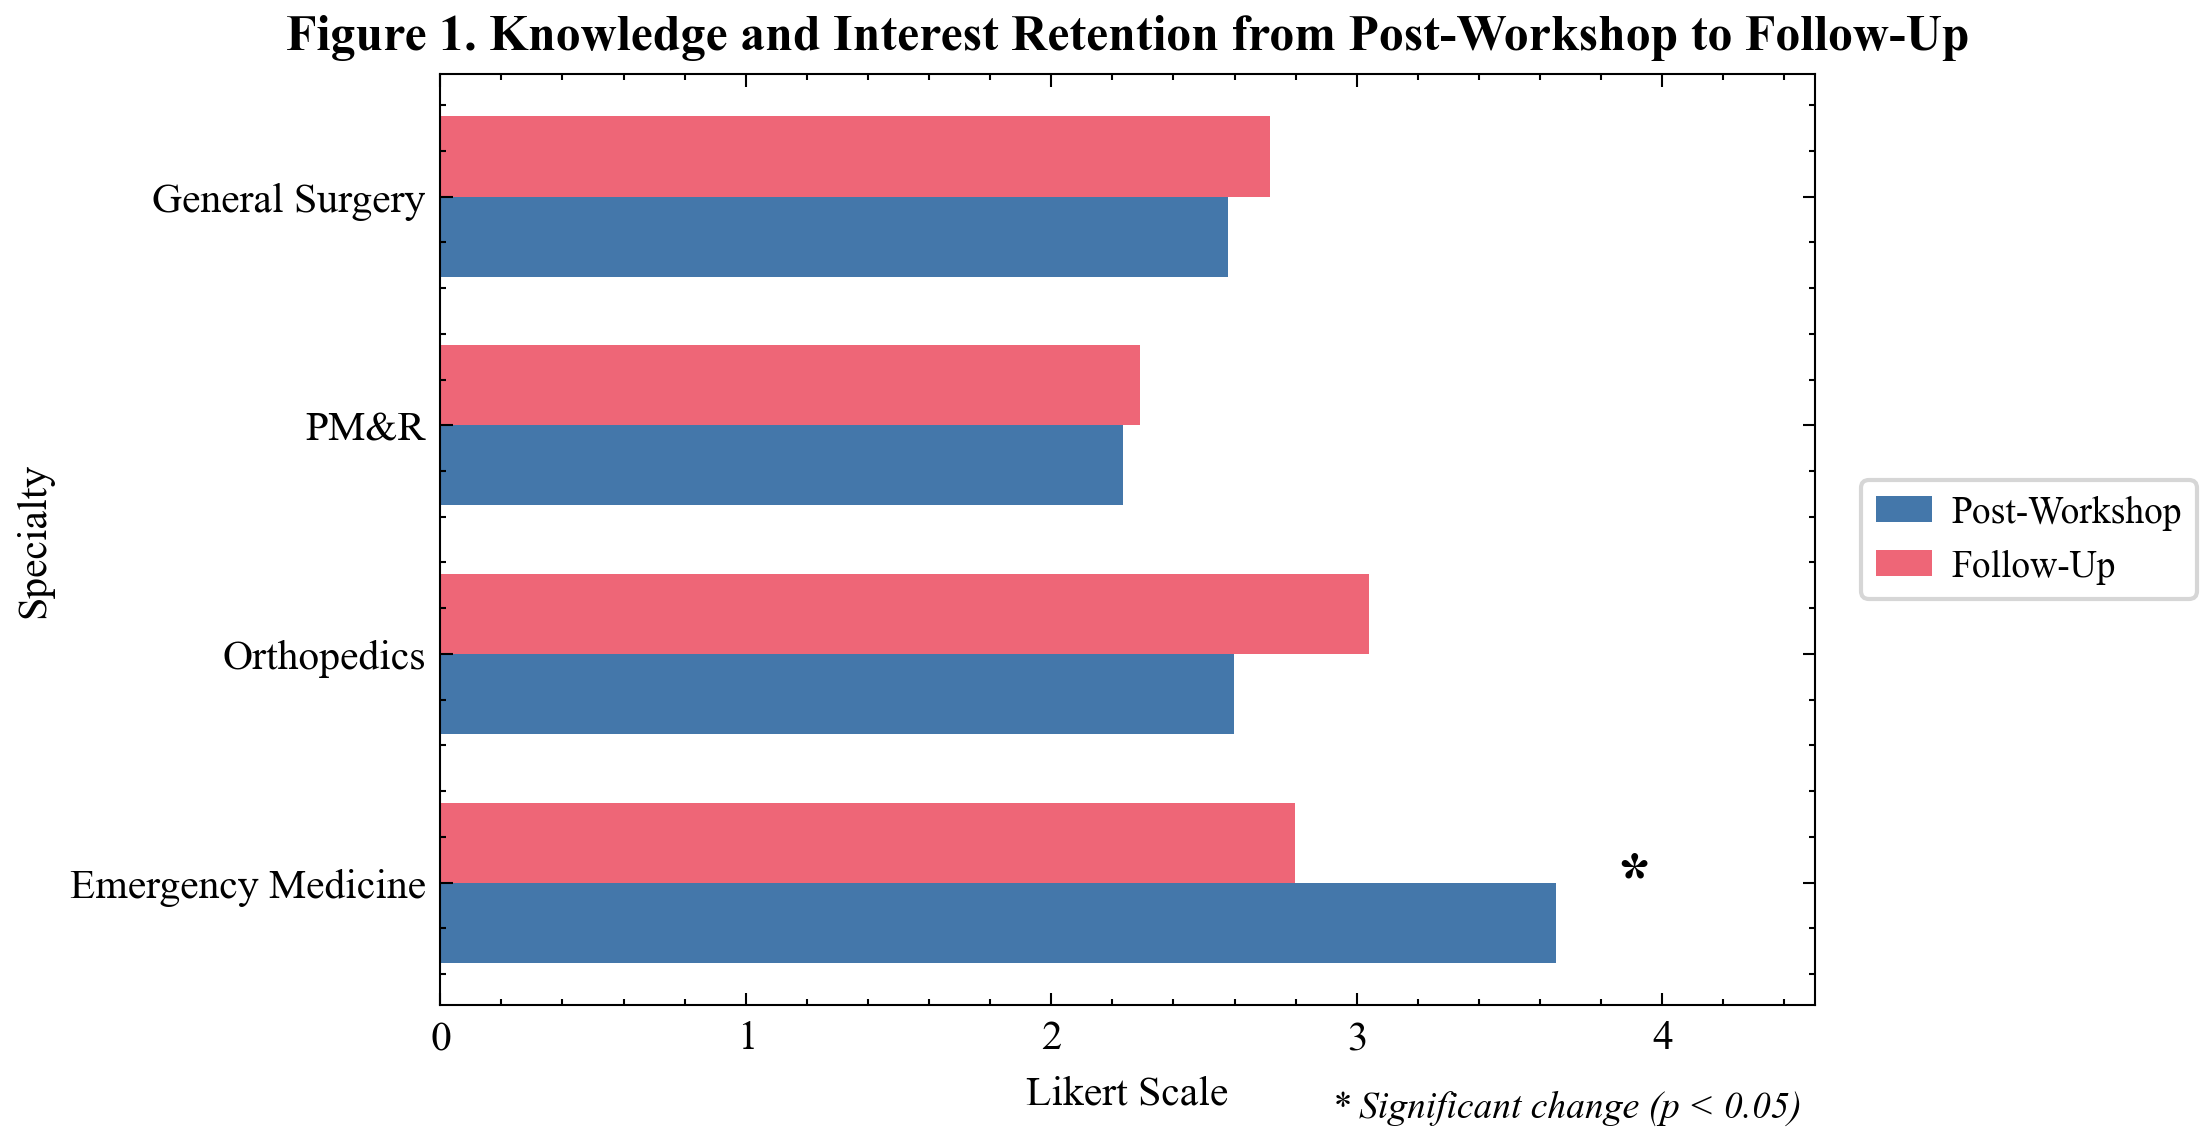

In [5]:
# Prepare grouped data
grouped_data = []
for workshop in ["Emergency Medicine", "Orthopedics", "PM&R", "General Surgery"]:
    data = retention_df[retention_df["Workshop"] == workshop]["Score"].values
    grouped_data.extend([
        {"Specialty": workshop, "Time": "Post-Workshop", "Score": data[0]},
        {"Specialty": workshop, "Time": "Follow-Up", "Score": data[1]}
    ])

grouped_df = pd.DataFrame(grouped_data)

# Create figure with extra space for legend
plt.figure(figsize=(7.5, 4))
ax = plt.gca()

# Create grouped bars
specialties = grouped_df["Specialty"].unique()
x = range(len(specialties))
width = 0.35

post_scores = grouped_df[grouped_df["Time"] == "Post-Workshop"]["Score"].values
fu_scores = grouped_df[grouped_df["Time"] == "Follow-Up"]["Score"].values

bars1 = ax.barh([i - width/2 for i in x], post_scores, width, label='Post-Workshop')
bars2 = ax.barh([i + width/2 for i in x], fu_scores, width, label='Follow-Up')

ax.set_xlabel("Likert Scale")
ax.set_ylabel("Specialty")
ax.set_title("Figure 1. Knowledge and Interest Retention from Post-Workshop to Follow-Up", fontweight='bold')
ax.set_xlim(0, 4.5)  # Extended slightly for asterisk space
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks(x)
ax.set_yticklabels(specialties)

# Add significance asterisks with clear spacing
for i, workshop in enumerate(specialties):
    if sig_info[workshop]["significant"]:
        # Get the maximum score for this workshop
        max_score = max(post_scores[i], fu_scores[i])
        
        # Place asterisk with adequate spacing from bars
        ax.text(max_score + 0.2, i, "*", fontsize=16, va='center', 
                weight='bold', color='black')

# Place legend outside the plot area to the right
ax.legend(frameon=True, loc='center left', bbox_to_anchor=(1.02, 0.5), 
          fontsize=9, handlelength=1.5, handletextpad=0.5)

# Add footnote
ax.text(0.99, -0.12, "* Significant change (p < 0.05)", 
        ha='right', style='italic', transform=ax.transAxes, fontsize=9)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.subplots_adjust(right=0.82)  # Make room for external legend
plt.savefig("Manuscript/Fig1_retention_grouped_bars.png", bbox_inches="tight")
plt.show()

Cell 6: Figure 1 (4 corners bar graph)

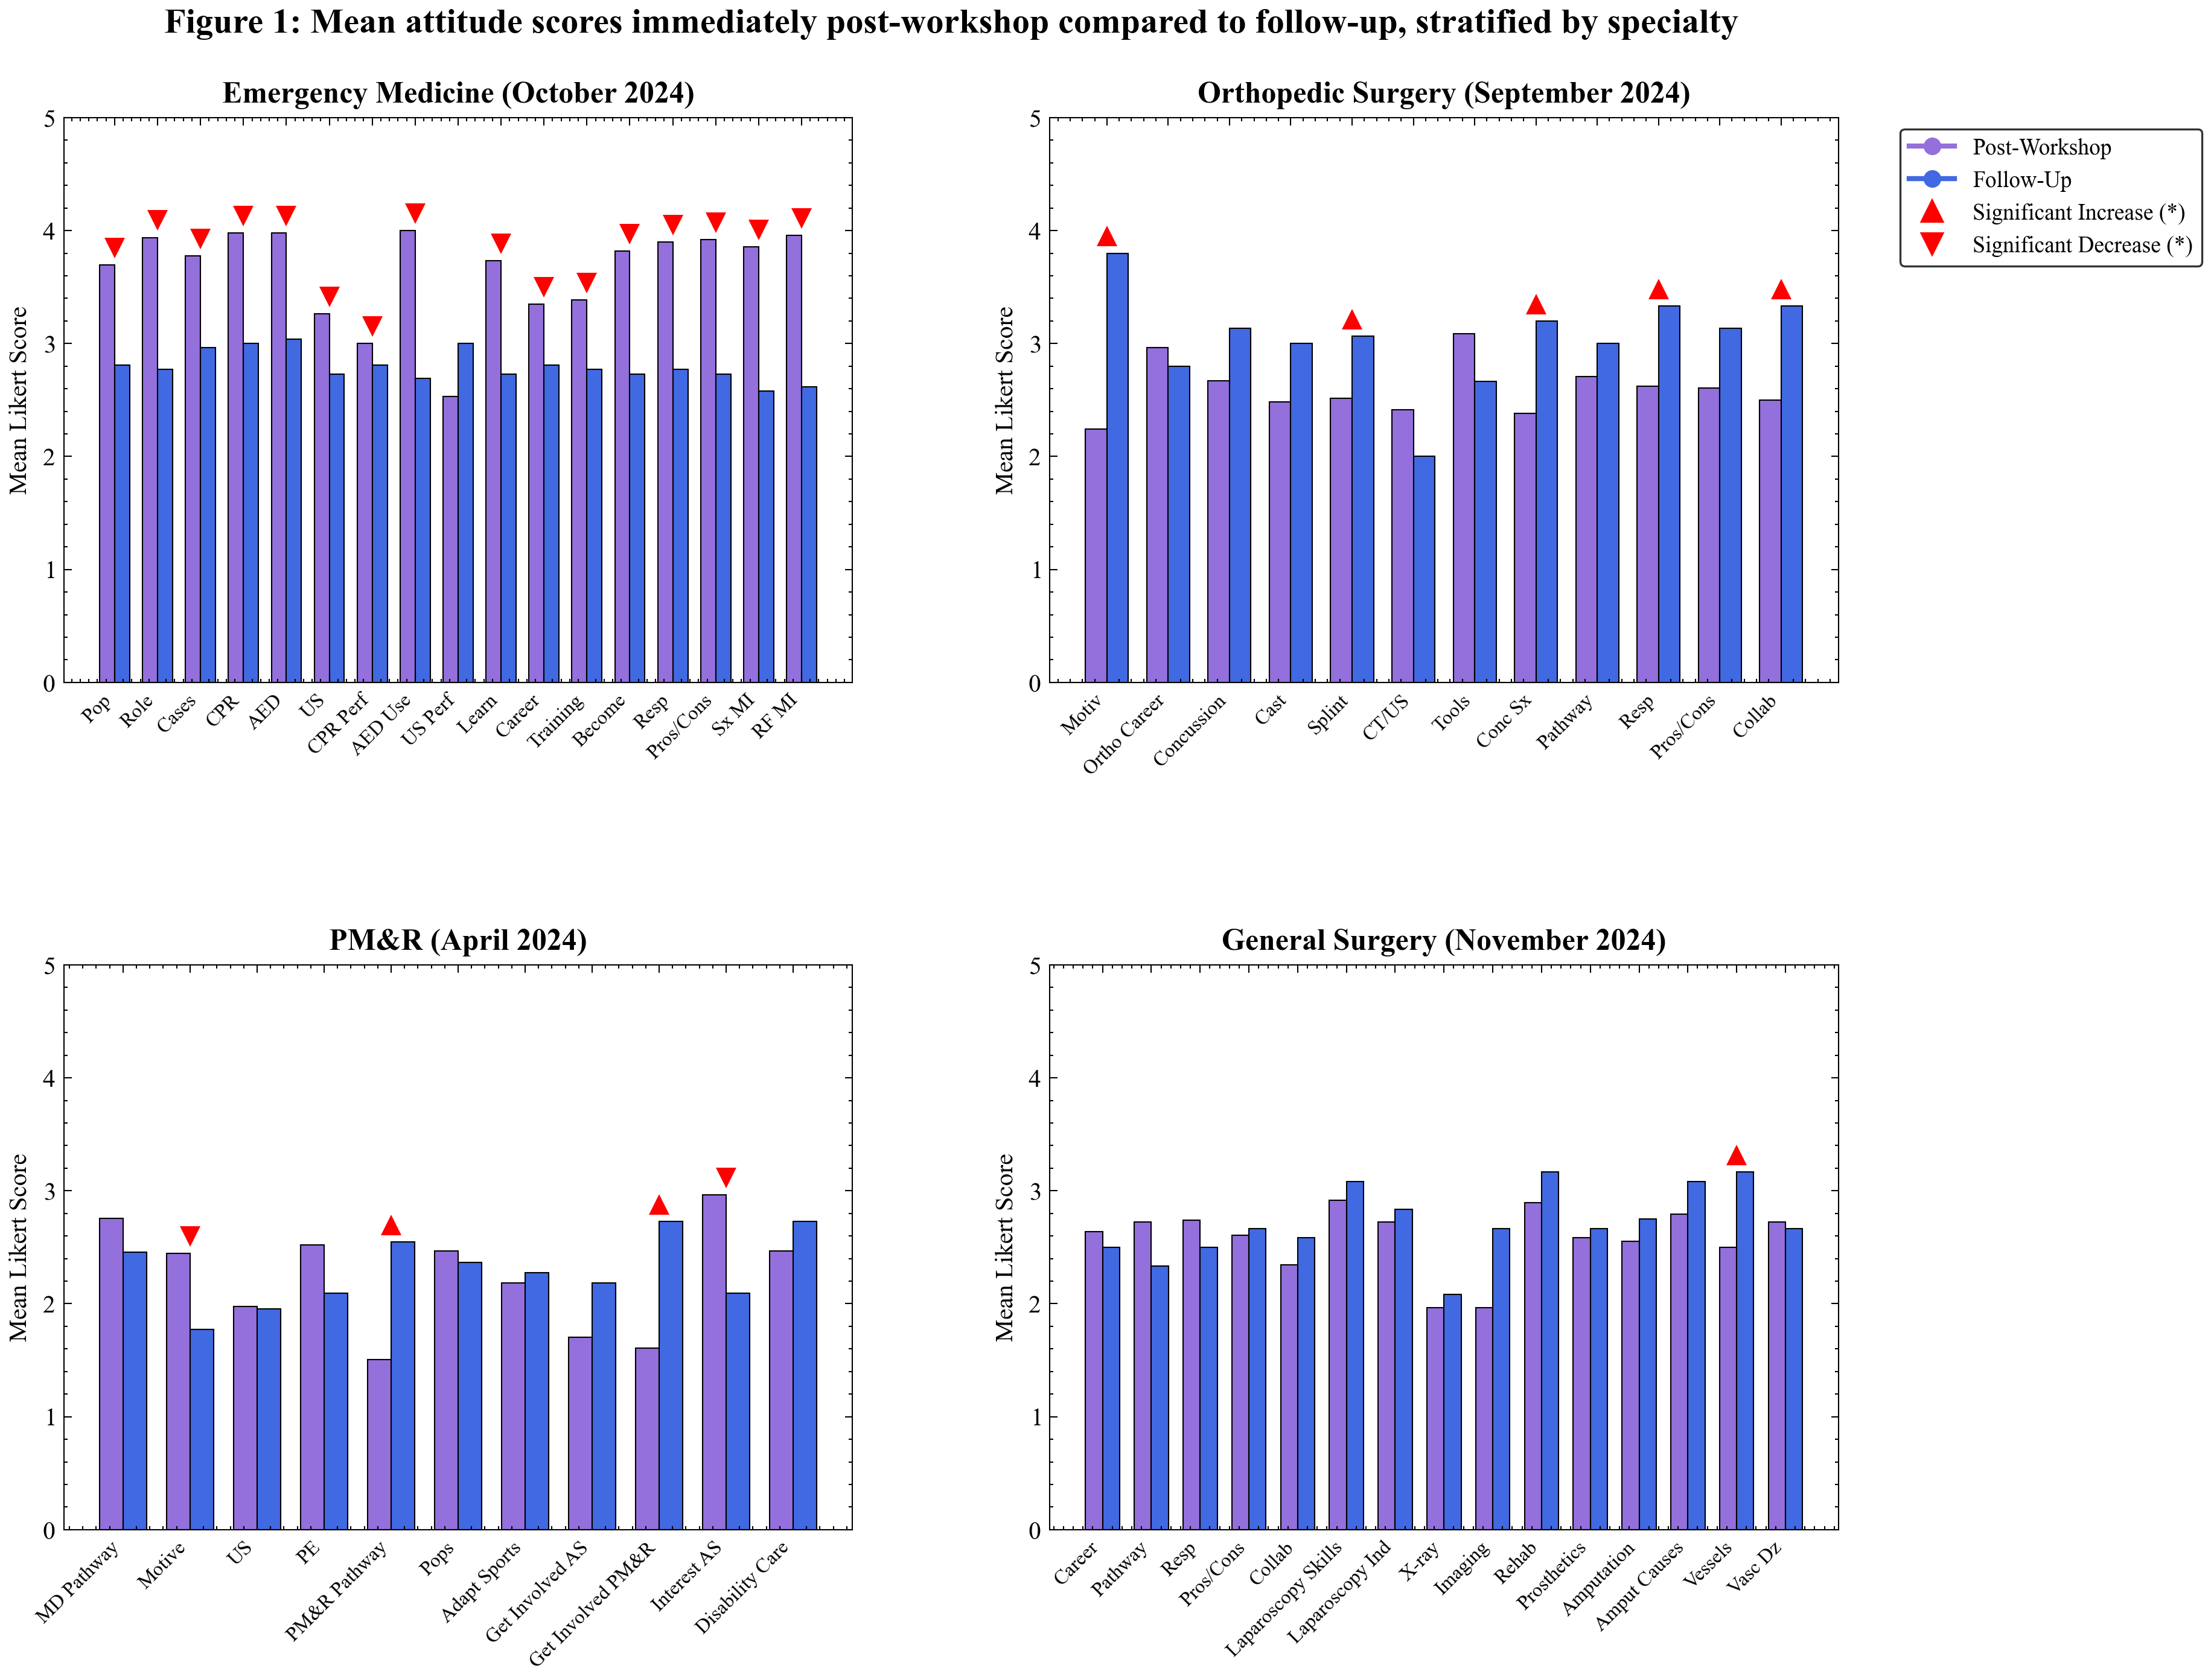

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

# Set publication style - this is the primary style driver
plt.style.use(['science', 'no-latex', 'bright'])
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'figure.dpi': 300,
    'savefig.dpi': 300
})

# Load workbook
workbook = "All Workshop Analysis .xlsx"

# Define workshops data (no changes here)
workshops = {
    "Emergency Medicine": {
        "sheet": "EM_Analysis",
        "date": "October 2024",
        "abbreviations": {
            "Attitude_EM_Population": "Pop", "Attitude_Role_EM_Physicians": "Role", "Attitude_EM_Cases_Referred_PMR": "Cases",
            "Attitude_Importance_CPR": "CPR", "Attitude_Importance_AED": "AED", "Attitude_Cardiac_Ultrasound": "US",
            "Attitude_Performing_CPR": "CPR Perf", "Attitude_Using_AED": "AED Use", "Attitude_Performing_Cardiac_Ultrasound": "US Perf",
            "Attitude_Learning_More_ About_EM": "Learn", "Attitude_Career_EM": "Career", "Attitude_More_Training_EM": "Training",
            "Attitude_Become_EM_Physician": "Become", "Attitude_Responsibilities_EM_Physician": "Resp", "Attitude_Pros_Cons_EM": "Pros/Cons",
            "Attitude_Symptoms_Heart_Attack": "Sx MI", "Attitude_RIsk_Factors_Heart_Attack": "RF MI"
        }
    },
    "Orthopedic Surgery": {
        "sheet": "Ortho_Analysis",
        "date": "September 2024",
        "abbreviations": {
            "Select a response that best describe your attitude - I feel motivated to pursue a career in medicine.": "Motiv",
            "Select a response that best describe your attitude - I am interested in pursuing a career in Orthopedic Surgery.": "Ortho Career",
            "Select a response that best describe your attitude - I understand the basics of performing concussion sideline assessments.": "Concussion",
            "Select a response that best describe your attitude - I understand how to apply a cast to a patient.": "Cast",
            "Select a response that best describe your attitude - I understand how to apply a splint to a patient.": "Splint",
            "Select a response that best describe your attitude - I understand how to perform a knee/carpal tunnel ultrasound.": "CT/US",
            "Select a response that best describe your attitude - I am familiar with Orthopedic surgical tools.": "Tools",
            "Select a response that best describe your attitude - I understand the causes and symptoms of a concussion.": "Conc Sx",
            "Select a response that best describe your attitude - I understand how to become an Orthopedic Surgeon.": "Pathway",
            "Select a response that best describe your attitude - I understand the responsibilities of an Orthopedic Surgeon.": "Resp",
            "Select a response that best describe your attitude - I understand the pros and cons of a career in Orthopedic Surgery.": "Pros/Cons",
            "Select a response that best describe your attitude - I understand the ways in which Orthopedic Surgeons collaborate with PM&R physicians.": "Collab"
        }
    },
    "PM&R": {
        "sheet": "PMR_Analysis",
        "date": "April 2024",
        "abbreviations": {
            "Select a response that best describe your attitude (PM&R) - I understand how to become a physician.": "MD Pathway",
            "Select a response that best describe your attitude (PM&R) - I feel motivated about applying to medical school.": "Motive",
            "Select a response that best describe your attitude (PM&R) - I understand the basics of performing an ultrasound.": "US",
            "Select a response that best describe your attitude (PM&R) - I understand the basics of performing a physical exam.": "PE",
            "Select a response that best describe your attitude (PM&R) - I understand how to become a PM&R physician.": "PM&R Pathway",
            "Select a response that best describe your attitude (PM&R) - I understand what patient population PM&R physicians serve.": "Pops",
            "Select a response that best describe your attitude (PM&R) - I understand what adaptive sports is.": "Adapt Sports",
            "Select a response that best describe your attitude (PM&R) - I feel k0wledgeable about ways to become involved in adaptive sports.": "Get Involved AS",
            "Select a response that best describe your attitude (PM&R) - I feel k0wledgeable about ways to become involved in PM&R.": "Get Involved PM&R",
            "Select a response that best describe your attitude (PM&R) - I am interested in being involved in adaptive sports.": "Interest AS",
            "Select a response that best describe your attitude (PM&R) - I am interested in learning about disability care.": "Disability Care"
        }
    },
    "General Surgery": {
        "sheet": "GenSurg_Analysis",
        "date": "November 2024",
        "abbreviations": {
            "Select a response that best describe your attitude - I am interested in pursuing a career in surgery": "Career",
            "Select a response that best describe your attitude - I understand how to become a surgeon": "Pathway",
            "Select a response that best describe your attitude - I understand the responsibilities of a surgeon": "Resp",
            "Select a response that best describe your attitude - I understand the pros and cons of a career in surgery": "Pros/Cons",
            "Select a response that best describe your attitude - I understand the ways in which surgeons collaborate with PM&R Physician": "Collab",
            "Select a response that best describe your attitude - I feel confident with basic laparoscopic skills": "Laparoscopy Skills",
            "Select a response that best describe your attitude - I understand the indications for laparoscopy in surgery": "Laparoscopy Ind",
            "Select a response that best describe your attitude - I am familiar with interpreting basic musculoskeletal radiographic images": "X-ray",
            "Select a response that best describe your attitude - I understand how to differentiate between an CT Scan, X-Ray, and MRI": "Imaging",
            "Select a response that best describe your attitude - I can describe the phases of rehabilitation following an amputation": "Rehab",
            "Select a response that best describe your attitude - I am understand the various types of prosthetic devices available": "Prosthetics",
            "Select a response that best describe your attitude - I can identify different types of amputations (e.g., upper limb, lower limb)": "Amputation",
            "Select a response that best describe your attitude - I can describe common medical and traumatic causes for amputations": "Amput Causes",
            "Select a response that best describe your attitude - I can identify the major blood vessels in the human body and their functions": "Vessels",
            "Select a response that best describe your attitude - I can describe common vascular diseases": "Vasc Dz"
        }
    }
}

# Create figure - DO NOT use tight_layout or constrained_layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MANUALLY create the main title using fig.text for precise control
fig.text(0.43, 0.96, 'Figure 1: Mean attitude scores immediately post-workshop compared to follow-up, stratified by specialty',
         ha='center', va='top', fontsize=14, fontweight='bold')

# Flatten axes for easier iteration
axes = axes.flatten()

# Process each workshop
for idx, (workshop_name, workshop_info) in enumerate(workshops.items()):
    ax = axes[idx]
    df = pd.read_excel(workbook, sheet_name=workshop_info["sheet"], index_col=0)
    questions = list(workshop_info["abbreviations"].keys())
    labels = list(workshop_info["abbreviations"].values())
    
    post_scores, fu_scores, sig_info = [], [], []
    for question in questions:
        if question in df.columns:
            post_score = float(df.loc["mean_post", question]) if pd.notna(df.loc["mean_post", question]) else 0
            fu_score = float(df.loc["Mean_fu", question]) if pd.notna(df.loc["Mean_fu", question]) else 0
            post_scores.append(post_score)
            fu_scores.append(fu_score)
            
            stat_sig = str(df.loc["Stat Sig", question]).strip().upper() if "Stat Sig" in df.index else "NO"
            if stat_sig == "YES":
                if float(fu_score) > float(post_score): sig_info.append("up")
                else: sig_info.append("down")
            else:
                sig_info.append(None)

    if post_scores:
        x_pos = np.arange(len(labels))
        width = 0.35
        
        # Use original ax.bar to maintain scienceplots styling
        ax.bar(x_pos - width/2, post_scores, width, color='#9370DB', edgecolor='black', linewidth=0.5)
        ax.bar(x_pos + width/2, fu_scores, width, color='#4169E1', edgecolor='black', linewidth=0.5)
        
        for i, sig_dir in enumerate(sig_info):
            if sig_dir:
                y_pos = max(post_scores[i], fu_scores[i]) + 0.15
                marker = '^' if sig_dir == "up" else 'v'
                ax.plot(i, y_pos, marker, color='red', markersize=8, markeredgewidth=0)
        
        ax.set_ylabel('Mean Likert Score')
        ax.set_title(f'{workshop_name} ({workshop_info["date"]})', fontweight='bold', fontsize=12)
        ax.set_xlabel('')
        ax.set_ylim(0, 5)
        
        # FIX WARNING: Set ticks BEFORE setting labels
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)

# Create legend elements to EXACTLY match the pronounced line graph style
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#9370DB', marker='o', linestyle='-', markersize=6, linewidth=2, label='Post-Workshop'),
    Line2D([0], [0], color='#4169E1', marker='o', linestyle='-', markersize=6, linewidth=2, label='Follow-Up'),
    Line2D([0], [0], marker='^', color='red', linestyle='None', markersize=8, label='Significant Increase (*)'),
    Line2D([0], [0], marker='v', color='red', linestyle='None', markersize=8, label='Significant Decrease (*)')
]

# Place legend in the reserved space on the right
legend = fig.legend(handles=legend_elements, 
                   loc='upper left',
                   bbox_to_anchor=(0.8, 0.9), # Position in the top of the right-hand column
                   fontsize=9,
                   frameon=True) # Add the box around the legend
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.8)

# MANUALLY ADJUST SPACING: This is the key to fixing all layout issues
plt.subplots_adjust(
    left=0.08,
    right=0.78,  # Squeeze plots to the left, creating a column for the legend
    top=0.90,    # Create space for the manual fig.text title
    bottom=0.12, # Add more space at the bottom for rotated labels
    hspace=0.5,  # Add vertical space between subplot rows
    wspace=0.25  # Add horizontal space between subplot columns
)

# Save figure
plt.savefig("Manuscript/Fig1_attitude_scores_by_specialty_bars.png", dpi=300, bbox_inches="tight")
plt.show()

Cell 7: Figure 1 (4 corners line graph)

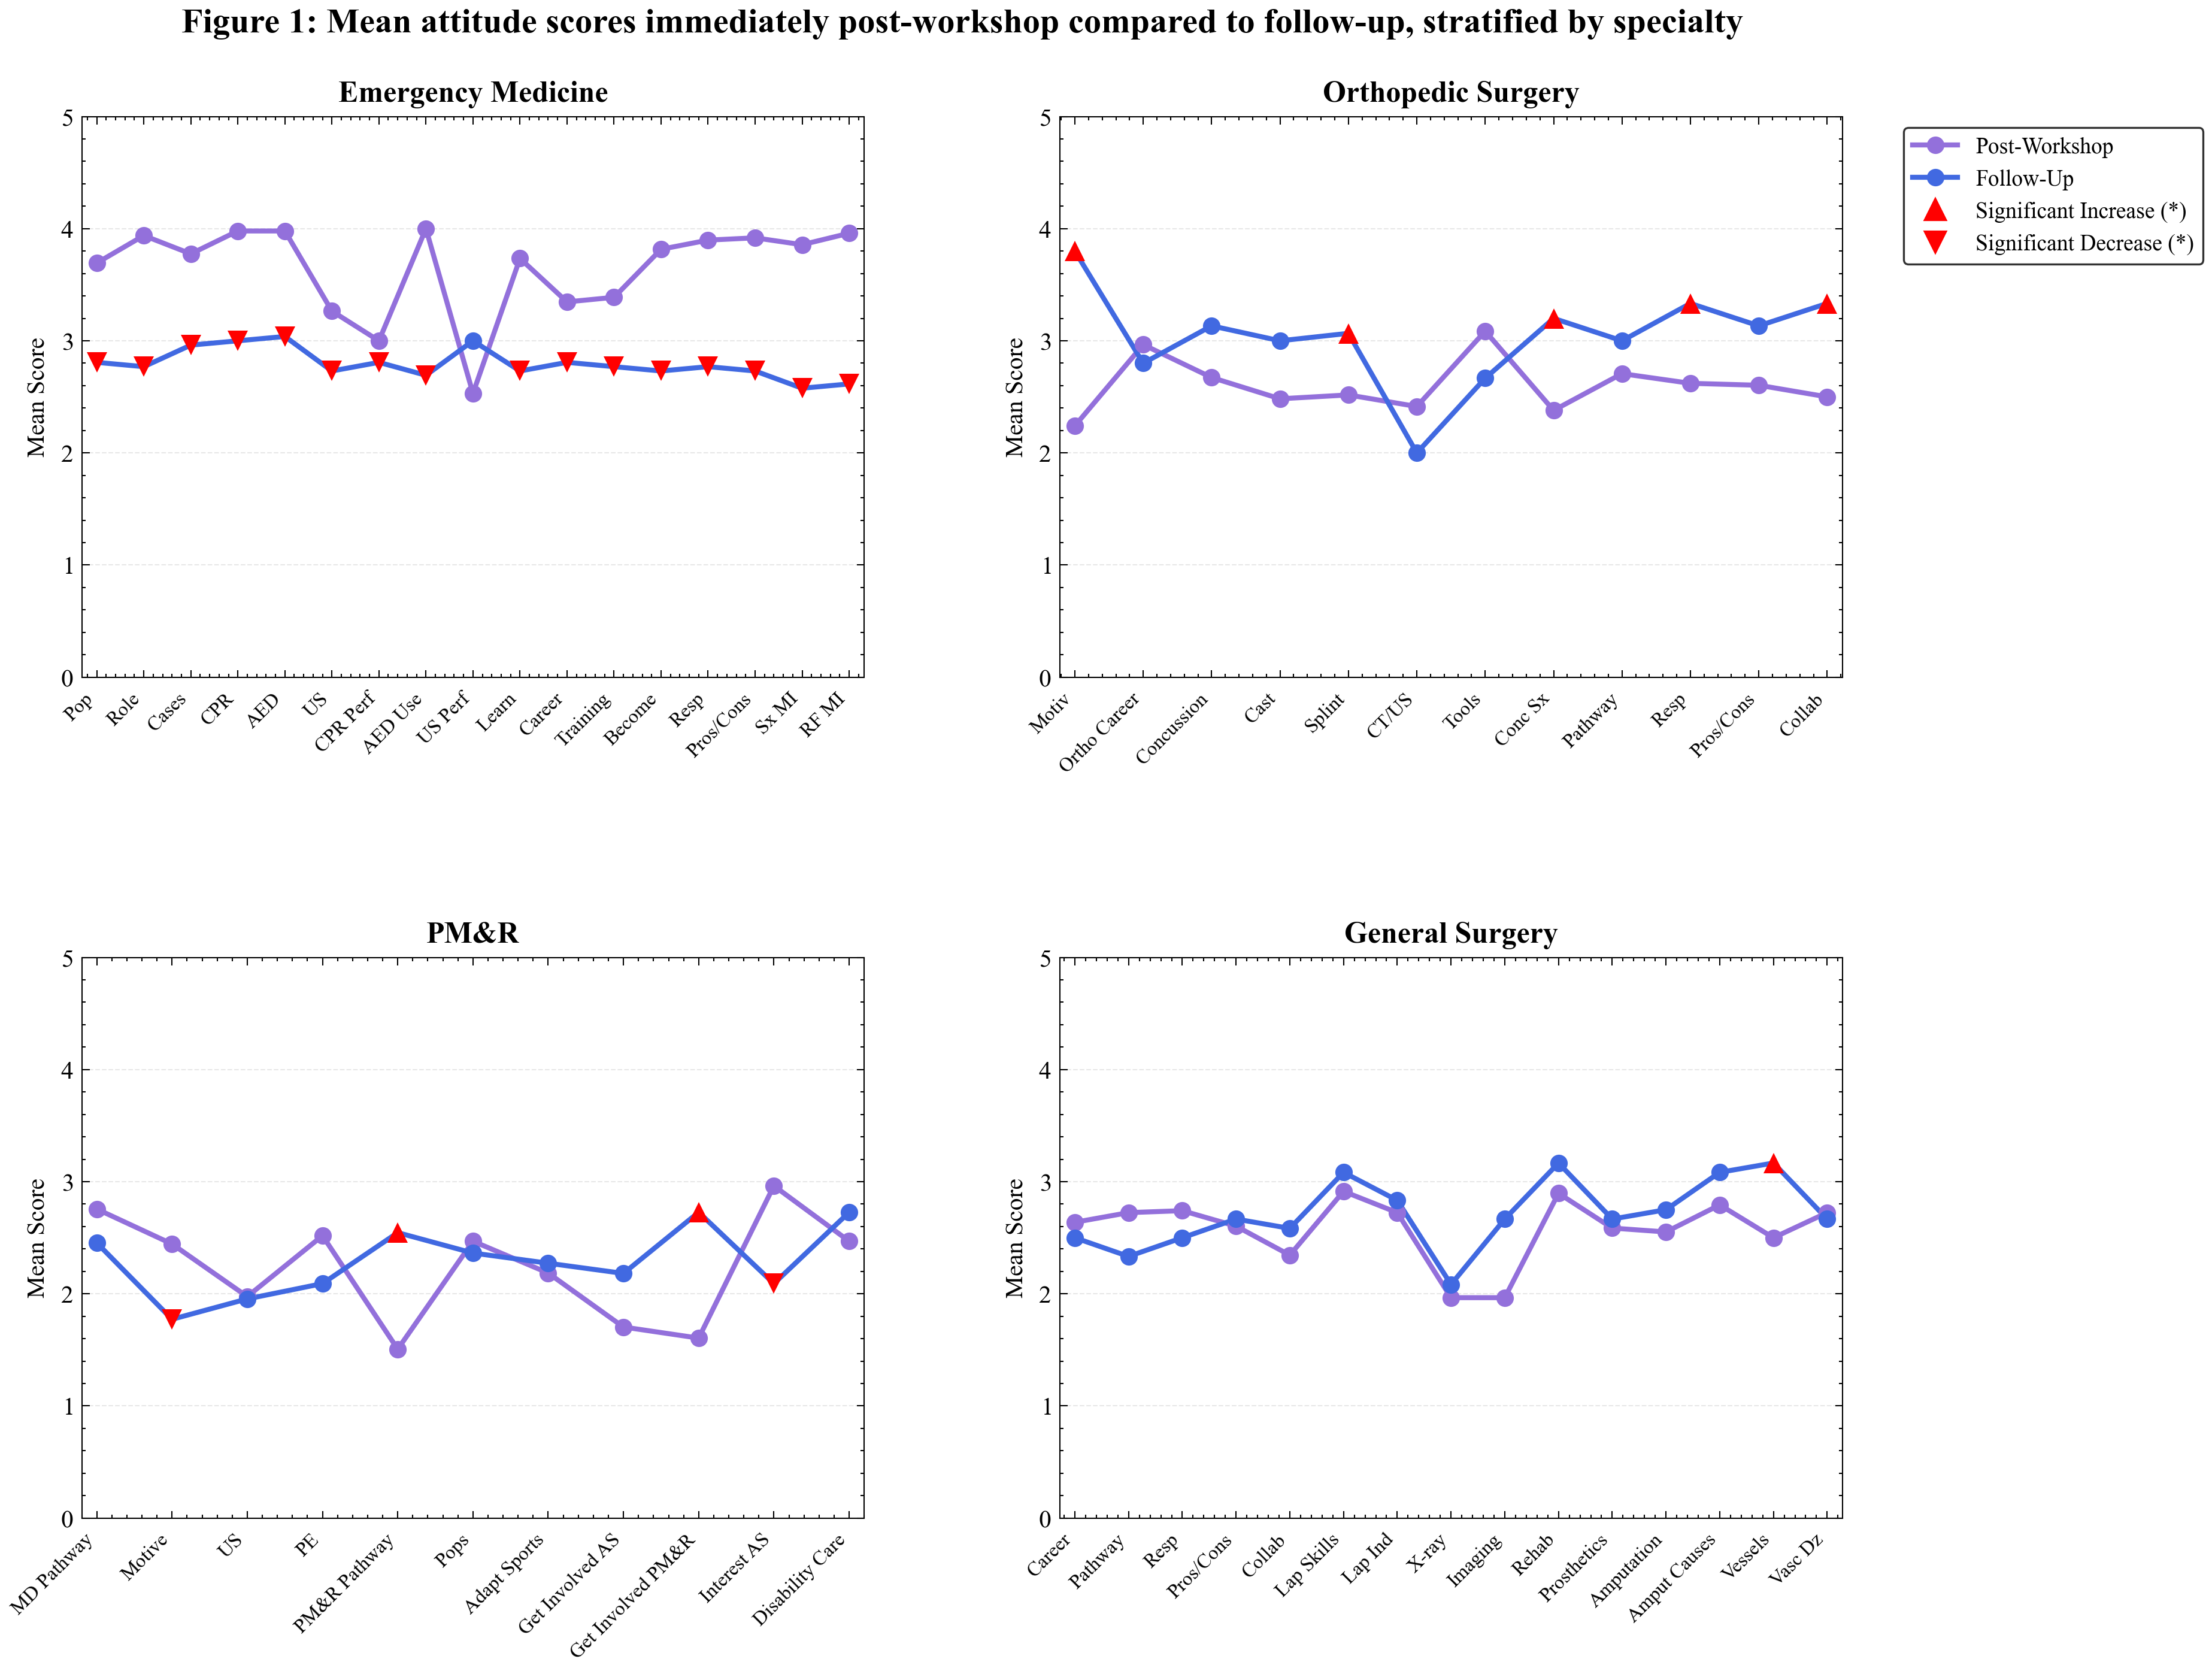

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

# Set publication style
plt.style.use(['science', 'no-latex', 'bright'])
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300
})

# Load workbook
workbook = "All Workshop Analysis .xlsx"

# Define workshops with descriptive labels
workshops = {
    "Emergency Medicine": {
        "sheet": "EM_Analysis",
        "abbreviations": {
            "Attitude_EM_Population": "Pop",
            "Attitude_Role_EM_Physicians": "Role",
            "Attitude_EM_Cases_Referred_PMR": "Cases",
            "Attitude_Importance_CPR": "CPR",
            "Attitude_Importance_AED": "AED",
            "Attitude_Cardiac_Ultrasound": "US",
            "Attitude_Performing_CPR": "CPR Perf",
            "Attitude_Using_AED": "AED Use",
            "Attitude_Performing_Cardiac_Ultrasound": "US Perf",
            "Attitude_Learning_More_ About_EM": "Learn",
            "Attitude_Career_EM": "Career",
            "Attitude_More_Training_EM": "Training",
            "Attitude_Become_EM_Physician": "Become",
            "Attitude_Responsibilities_EM_Physician": "Resp",
            "Attitude_Pros_Cons_EM": "Pros/Cons",
            "Attitude_Symptoms_Heart_Attack": "Sx MI",
            "Attitude_RIsk_Factors_Heart_Attack": "RF MI"
        }
    },
    "Orthopedic Surgery": {
        "sheet": "Ortho_Analysis",
        "abbreviations": {
            "Select a response that best describe your attitude - I feel motivated to pursue a career in medicine.": "Motiv",
            "Select a response that best describe your attitude - I am interested in pursuing a career in Orthopedic Surgery.": "Ortho Career",
            "Select a response that best describe your attitude - I understand the basics of performing concussion sideline assessments.": "Concussion",
            "Select a response that best describe your attitude - I understand how to apply a cast to a patient.": "Cast",
            "Select a response that best describe your attitude - I understand how to apply a splint to a patient.": "Splint",
            "Select a response that best describe your attitude - I understand how to perform a knee/carpal tunnel ultrasound.": "CT/US",
            "Select a response that best describe your attitude - I am familiar with Orthopedic surgical tools.": "Tools",
            "Select a response that best describe your attitude - I understand the causes and symptoms of a concussion.": "Conc Sx",
            "Select a response that best describe your attitude - I understand how to become an Orthopedic Surgeon.": "Pathway",
            "Select a response that best describe your attitude - I understand the responsibilities of an Orthopedic Surgeon.": "Resp",
            "Select a response that best describe your attitude - I understand the pros and cons of a career in Orthopedic Surgery.": "Pros/Cons",
            "Select a response that best describe your attitude - I understand the ways in which Orthopedic Surgeons collaborate with PM&R physicians.": "Collab"
        }
    },
    "PM&R": {
        "sheet": "PMR_Analysis",
        "abbreviations": {
            "Select a response that best describe your attitude (PM&R) - I understand how to become a physician.": "MD Pathway",
            "Select a response that best describe your attitude (PM&R) - I feel motivated about applying to medical school.": "Motive",
            "Select a response that best describe your attitude (PM&R) - I understand the basics of performing an ultrasound.": "US",
            "Select a response that best describe your attitude (PM&R) - I understand the basics of performing a physical exam.": "PE",
            "Select a response that best describe your attitude (PM&R) - I understand how to become a PM&R physician.": "PM&R Pathway",
            "Select a response that best describe your attitude (PM&R) - I understand what patient population PM&R physicians serve.": "Pops",
            "Select a response that best describe your attitude (PM&R) - I understand what adaptive sports is.": "Adapt Sports",
            "Select a response that best describe your attitude (PM&R) - I feel k0wledgeable about ways to become involved in adaptive sports.": "Get Involved AS",
            "Select a response that best describe your attitude (PM&R) - I feel k0wledgeable about ways to become involved in PM&R.": "Get Involved PM&R",
            "Select a response that best describe your attitude (PM&R) - I am interested in being involved in adaptive sports.": "Interest AS",
            "Select a response that best describe your attitude (PM&R) - I am interested in learning about disability care.": "Disability Care"
        }
    },
    "General Surgery": {
        "sheet": "GenSurg_Analysis",
        "abbreviations": {
            "Select a response that best describe your attitude - I am interested in pursuing a career in surgery": "Career",
            "Select a response that best describe your attitude - I understand how to become a surgeon": "Pathway",
            "Select a response that best describe your attitude - I understand the responsibilities of a surgeon": "Resp",
            "Select a response that best describe your attitude - I understand the pros and cons of a career in surgery": "Pros/Cons",
            "Select a response that best describe your attitude - I understand the ways in which surgeons collaborate with PM&R Physician": "Collab",
            "Select a response that best describe your attitude - I feel confident with basic laparoscopic skills": "Lap Skills",
            "Select a response that best describe your attitude - I understand the indications for laparoscopy in surgery": "Lap Ind",
            "Select a response that best describe your attitude - I am familiar with interpreting basic musculoskeletal radiographic images": "X-ray",
            "Select a response that best describe your attitude - I understand how to differentiate between an CT Scan, X-Ray, and MRI": "Imaging",
            "Select a response that best describe your attitude - I can describe the phases of rehabilitation following an amputation": "Rehab",
            "Select a response that best describe your attitude - I am understand the various types of prosthetic devices available": "Prosthetics",
            "Select a response that best describe your attitude - I can identify different types of amputations (e.g., upper limb, lower limb)": "Amputation",
            "Select a response that best describe your attitude - I can describe common medical and traumatic causes for amputations": "Amput Causes",
            "Select a response that best describe your attitude - I can identify the major blood vessels in the human body and their functions": "Vessels",
            "Select a response that best describe your attitude - I can describe common vascular diseases": "Vasc Dz"
        }
    }
}

# Create figure with matching proportions - DO NOT use tight_layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# MANUALLY create the main title using fig.text for precise control
fig.text(0.43, 0.96, 'Figure 1: Mean attitude scores immediately post-workshop compared to follow-up, stratified by specialty',
         ha='center', va='top', fontsize=14, fontweight='bold')

# Process each workshop
for idx, (workshop_name, workshop_info) in enumerate(workshops.items()):
    ax = axes[idx]
    
    # Load data
    df = pd.read_excel(workbook, sheet_name=workshop_info["sheet"], index_col=0)
    
    # Get question columns and their abbreviations
    questions = list(workshop_info["abbreviations"].keys())
    labels = list(workshop_info["abbreviations"].values())
    
    # Extract data for line plot
    post_scores = []
    fu_scores = []
    sig_info = []
    
    for question in questions:
        if question in df.columns:
            post_score = df.loc["mean_post", question]
            fu_score = df.loc["Mean_fu", question]
            
            # Check significance and direction
            try:
                stat_sig = str(df.loc["Stat Sig", question]).strip().upper() if "Stat Sig" in df.index else "NO"
                if stat_sig == "YES":
                    if float(fu_score) > float(post_score):
                        sig_info.append("up")
                    else:
                        sig_info.append("down")
                else:
                    sig_info.append(None)
            except (ValueError, TypeError):
                sig_info.append(None)
            
            post_scores.append(float(post_score) if pd.notna(post_score) else np.nan)
            fu_scores.append(float(fu_score) if pd.notna(fu_score) else np.nan)
    
    # Create x positions
    x = np.arange(len(labels))
    
    # Plot lines first (without markers)
    ax.plot(x, post_scores, '-', color='#9370DB', linewidth=2)
    ax.plot(x, fu_scores, '-', color='#4169E1', linewidth=2)
    
    # Add markers - circles for non-significant, triangles for significant
    for i in range(len(x)):
        ax.plot(i, post_scores[i], 'o', color='#9370DB', markersize=6)
        if sig_info[i] and i < len(fu_scores):
            if sig_info[i] == "up":
                ax.plot(i, fu_scores[i], '^', color='red', markersize=8, markeredgewidth=0)
            elif sig_info[i] == "down":
                ax.plot(i, fu_scores[i], 'v', color='red', markersize=8, markeredgewidth=0)
        else:
            ax.plot(i, fu_scores[i], 'o', color='#4169E1', markersize=6)
    
    # Customize subplot
    ax.set_ylabel('Mean Score')
    ax.set_title(workshop_name, fontweight='bold', fontsize=12) # Match bar chart font size
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylim(0, 5)
    ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.margins(x=0.02)
    ax.tick_params(axis='x', pad=5)

# Create legend elements to EXACTLY match the bar graph style
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#9370DB', marker='o', linestyle='-', markersize=6, linewidth=2, label='Post-Workshop'),
    Line2D([0], [0], color='#4169E1', marker='o', linestyle='-', markersize=6, linewidth=2, label='Follow-Up'),
    Line2D([0], [0], marker='^', color='red', linestyle='None', markersize=8, label='Significant Increase (*)'),
    Line2D([0], [0], marker='v', color='red', linestyle='None', markersize=8, label='Significant Decrease (*)')
]

# Place legend in the reserved space on the right
legend = fig.legend(handles=legend_elements, 
                   loc='upper left',
                   bbox_to_anchor=(0.8, 0.9), # Position in the top of the right-hand column
                   fontsize=9,
                   frameon=True) # Add the box around the legend
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.8)

# MANUALLY ADJUST SPACING: This is the key to fixing all layout issues
plt.subplots_adjust(
    left=0.08,
    right=0.78,  # Squeeze plots to the left, creating a column for the legend
    top=0.90,    # Create space for the manual fig.text title
    bottom=0.12, # Add more space at the bottom for rotated labels
    hspace=0.5,  # Add vertical space between subplot rows
    wspace=0.25  # Add horizontal space between subplot columns
)

# Save figure
plt.savefig("Manuscript/Fig1_attitude_scores_line_graph.png", dpi=300, bbox_inches="tight")
plt.show()

Cell 8: Figure 2 (2 subplots - Combined preferences of of Figure 2 & 3)

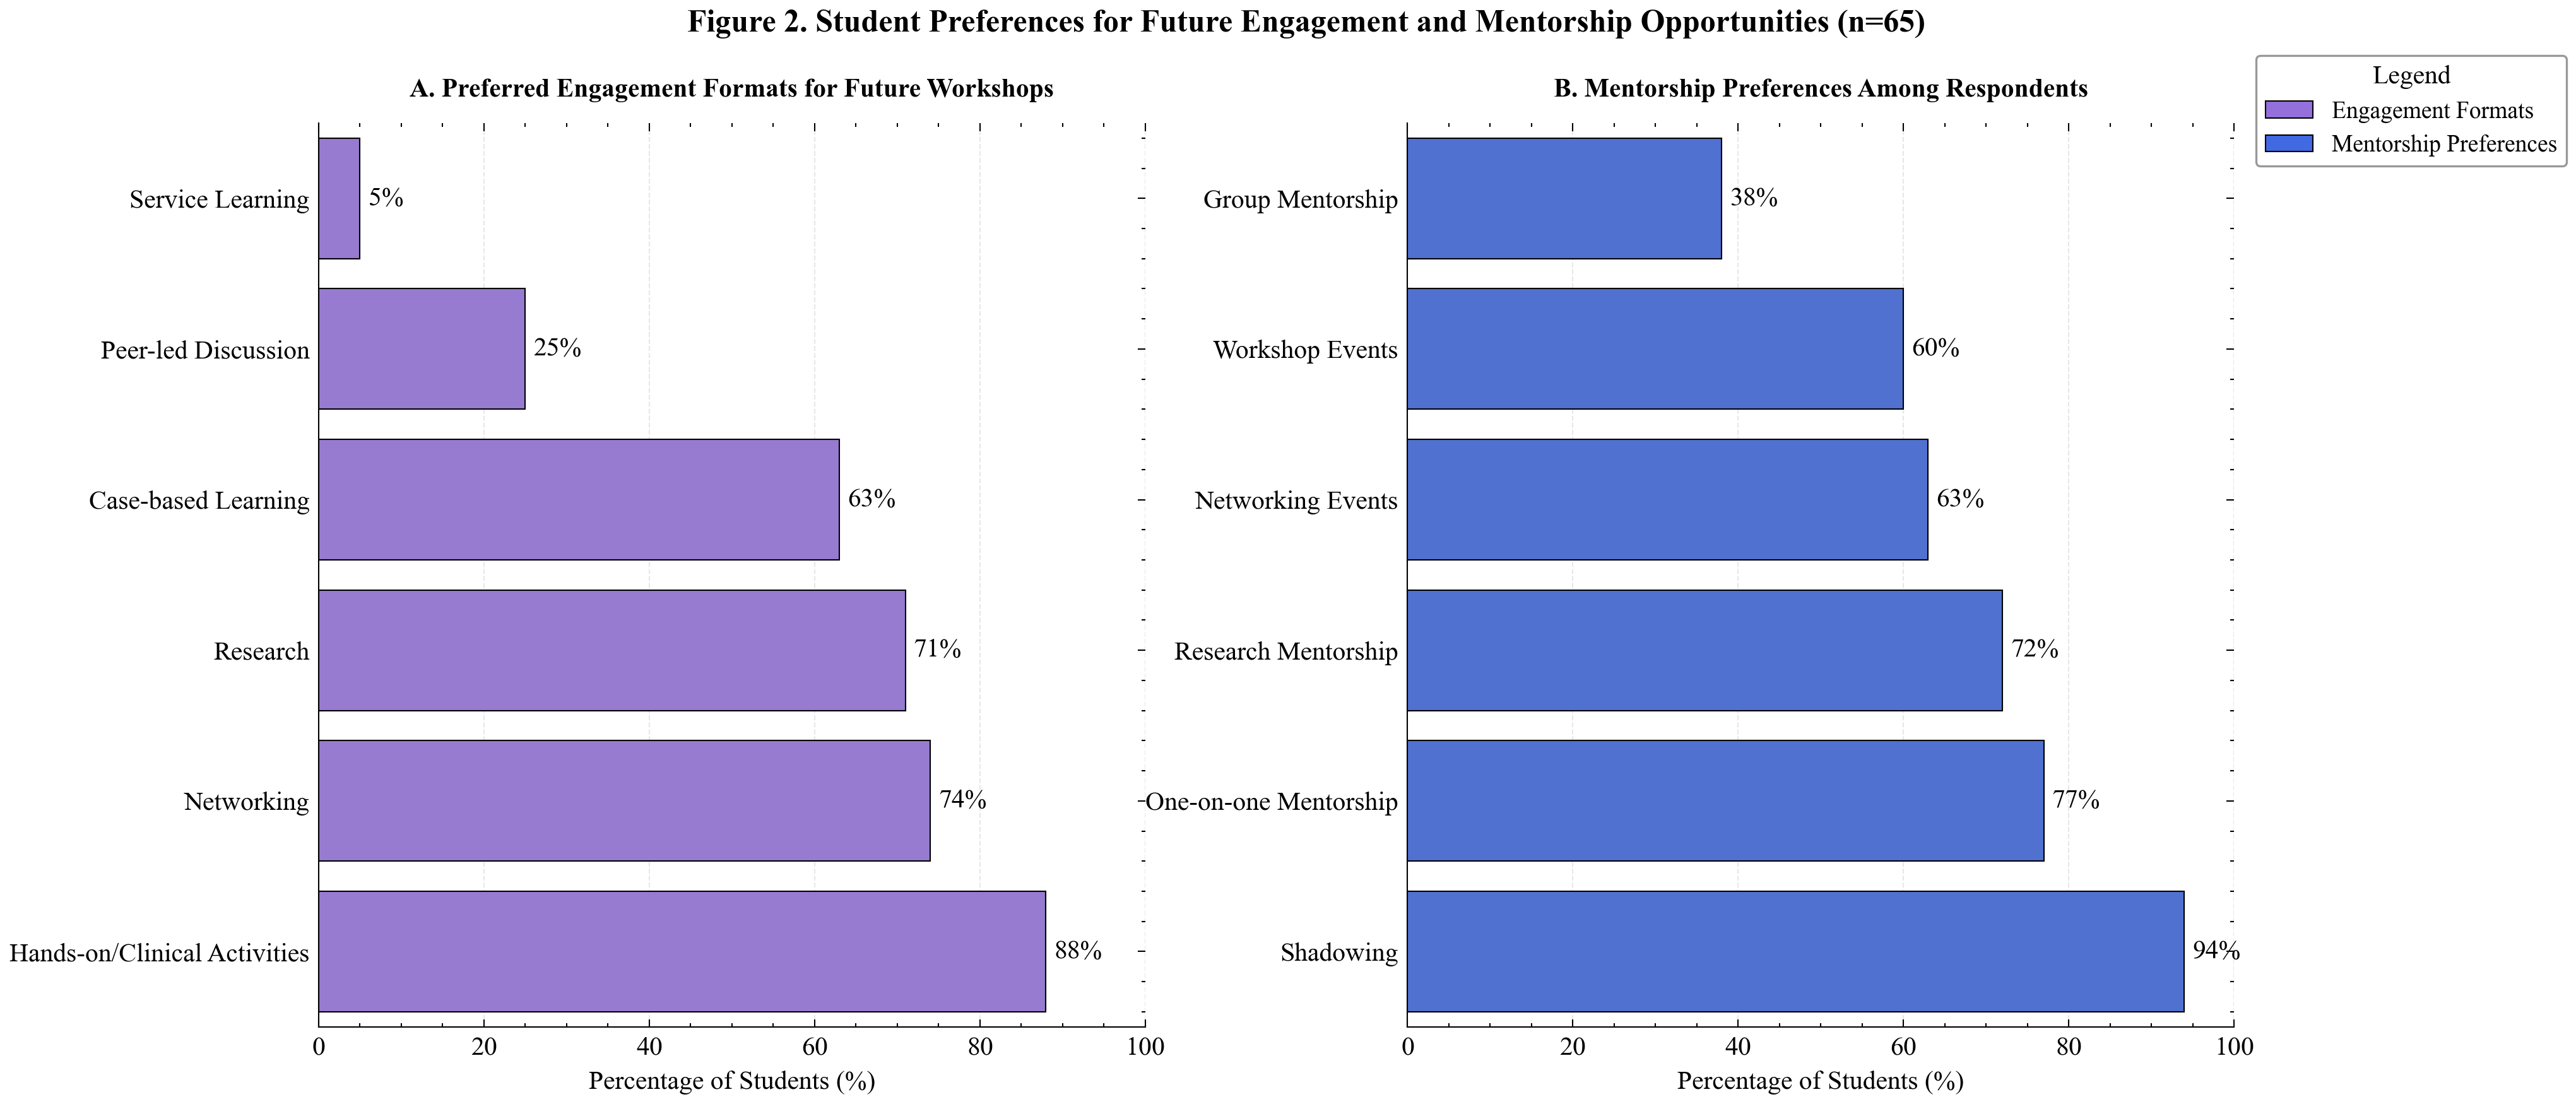

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scienceplots

# Set publication style
plt.style.use(['science', 'no-latex', 'bright'])
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300
})

# Define engagement data
engagement_data = {
    "Hands-on/Clinical Activities": 57,
    "Networking": 48,
    "Research": 46,
    "Case-based Learning": 41,
    "Peer-led Discussion": 16,
    "Service Learning": 3
}

# Define mentorship data
mentorship_data = {
    "Shadowing": 61,
    "One-on-one Mentorship": 50,
    "Research Mentorship": 47,
    "Networking Events": 41,
    "Workshop Events": 39,
    "Group Mentorship": 25
}

# Create DataFrames
engagement_df = pd.DataFrame([
    {"Method": method, "Percentage": round((count/65)*100)} 
    for method, count in engagement_data.items()
])
engagement_df = engagement_df.sort_values("Percentage", ascending=True)

mentorship_df = pd.DataFrame([
    {"Format": format_name, "Percentage": round((count/65)*100)}
    for format_name, count in mentorship_data.items()
])
mentorship_df = mentorship_df.sort_values("Percentage", ascending=True)

# Create figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot - Engagement Formats
ax1 = axes[0]
sns.barplot(
    data=engagement_df,
    y="Method",
    x="Percentage",
    ax=ax1,
    color="#9370DB",  # Purple color matching mean post-workshop
    saturation=0.8,
    edgecolor="black",
    linewidth=0.5
)

# Format left subplot
ax1.set_xlabel("Percentage of Students (%)", fontsize=10)
ax1.set_ylabel("", fontsize=10)
ax1.set_title("A. Preferred Engagement Formats for Future Workshops", 
             fontsize=10, fontweight='bold', pad=10)
ax1.tick_params(axis='both', labelsize=10)
ax1.set_xlim(0, 100)

# Add value labels for engagement
for i, (idx, row) in enumerate(engagement_df.iterrows()):
    ax1.text(row['Percentage'] + 1, i, f"{int(row['Percentage'])}%", 
            va='center', fontsize=10)

ax1.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax1.set_axisbelow(True)

# Right subplot - Mentorship Preferences
ax2 = axes[1]
sns.barplot(
    data=mentorship_df,
    y="Format",
    x="Percentage",
    ax=ax2,
    color="#4169E1",  # Blue color matching mean 3-month follow-up
    saturation=0.8,
    edgecolor="black",
    linewidth=0.5
)

# Format right subplot
ax2.set_xlabel("Percentage of Students (%)", fontsize=10)
ax2.set_ylabel("", fontsize=10)
ax2.set_title("B. Mentorship Preferences Among Respondents", 
             fontsize=10, fontweight='bold', pad=10)
ax2.tick_params(axis='both', labelsize=10)
ax2.set_xlim(0, 100)

# Add value labels for mentorship
for i, (idx, row) in enumerate(mentorship_df.iterrows()):
    ax2.text(row['Percentage'] + 1, i, f"{int(row['Percentage'])}%", 
            va='center', fontsize=10)

ax2.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax2.set_axisbelow(True)

# Remove top and right spines for both subplots
sns.despine(ax=ax1)
sns.despine(ax=ax2)

# Create legend elements
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#9370DB', edgecolor='black', linewidth=0.5, label='Engagement Formats'),
    Patch(facecolor='#4169E1', edgecolor='black', linewidth=0.5, label='Mentorship Preferences')
]

# Position legend in top right corner (non-overlapping)
legend = fig.legend(handles=legend_elements, 
                   loc='upper right',
                   bbox_to_anchor=(0.98, 0.95),
                   fontsize=9,
                   frameon=True,
                   fancybox=True,
                   shadow=False,
                   title='Legend',
                   title_fontsize=10)

# Style legend frame
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(0.8)

# Add main title
fig.suptitle("Figure 2. Student Preferences for Future Engagement and Mentorship Opportunities (n=65)", 
             fontsize=12, fontweight='bold', y=0.98)

# Adjust layout to accommodate legend
plt.tight_layout()
plt.subplots_adjust(top=0.88, right=0.85)

# Save figure
plt.savefig("Manuscript/Fig2_combined_preferences_2in1.png", dpi=300, bbox_inches="tight")
plt.show()

Cell 9: Figure 2 (1 subplot - Combined preferences of Figure 2 & 3)

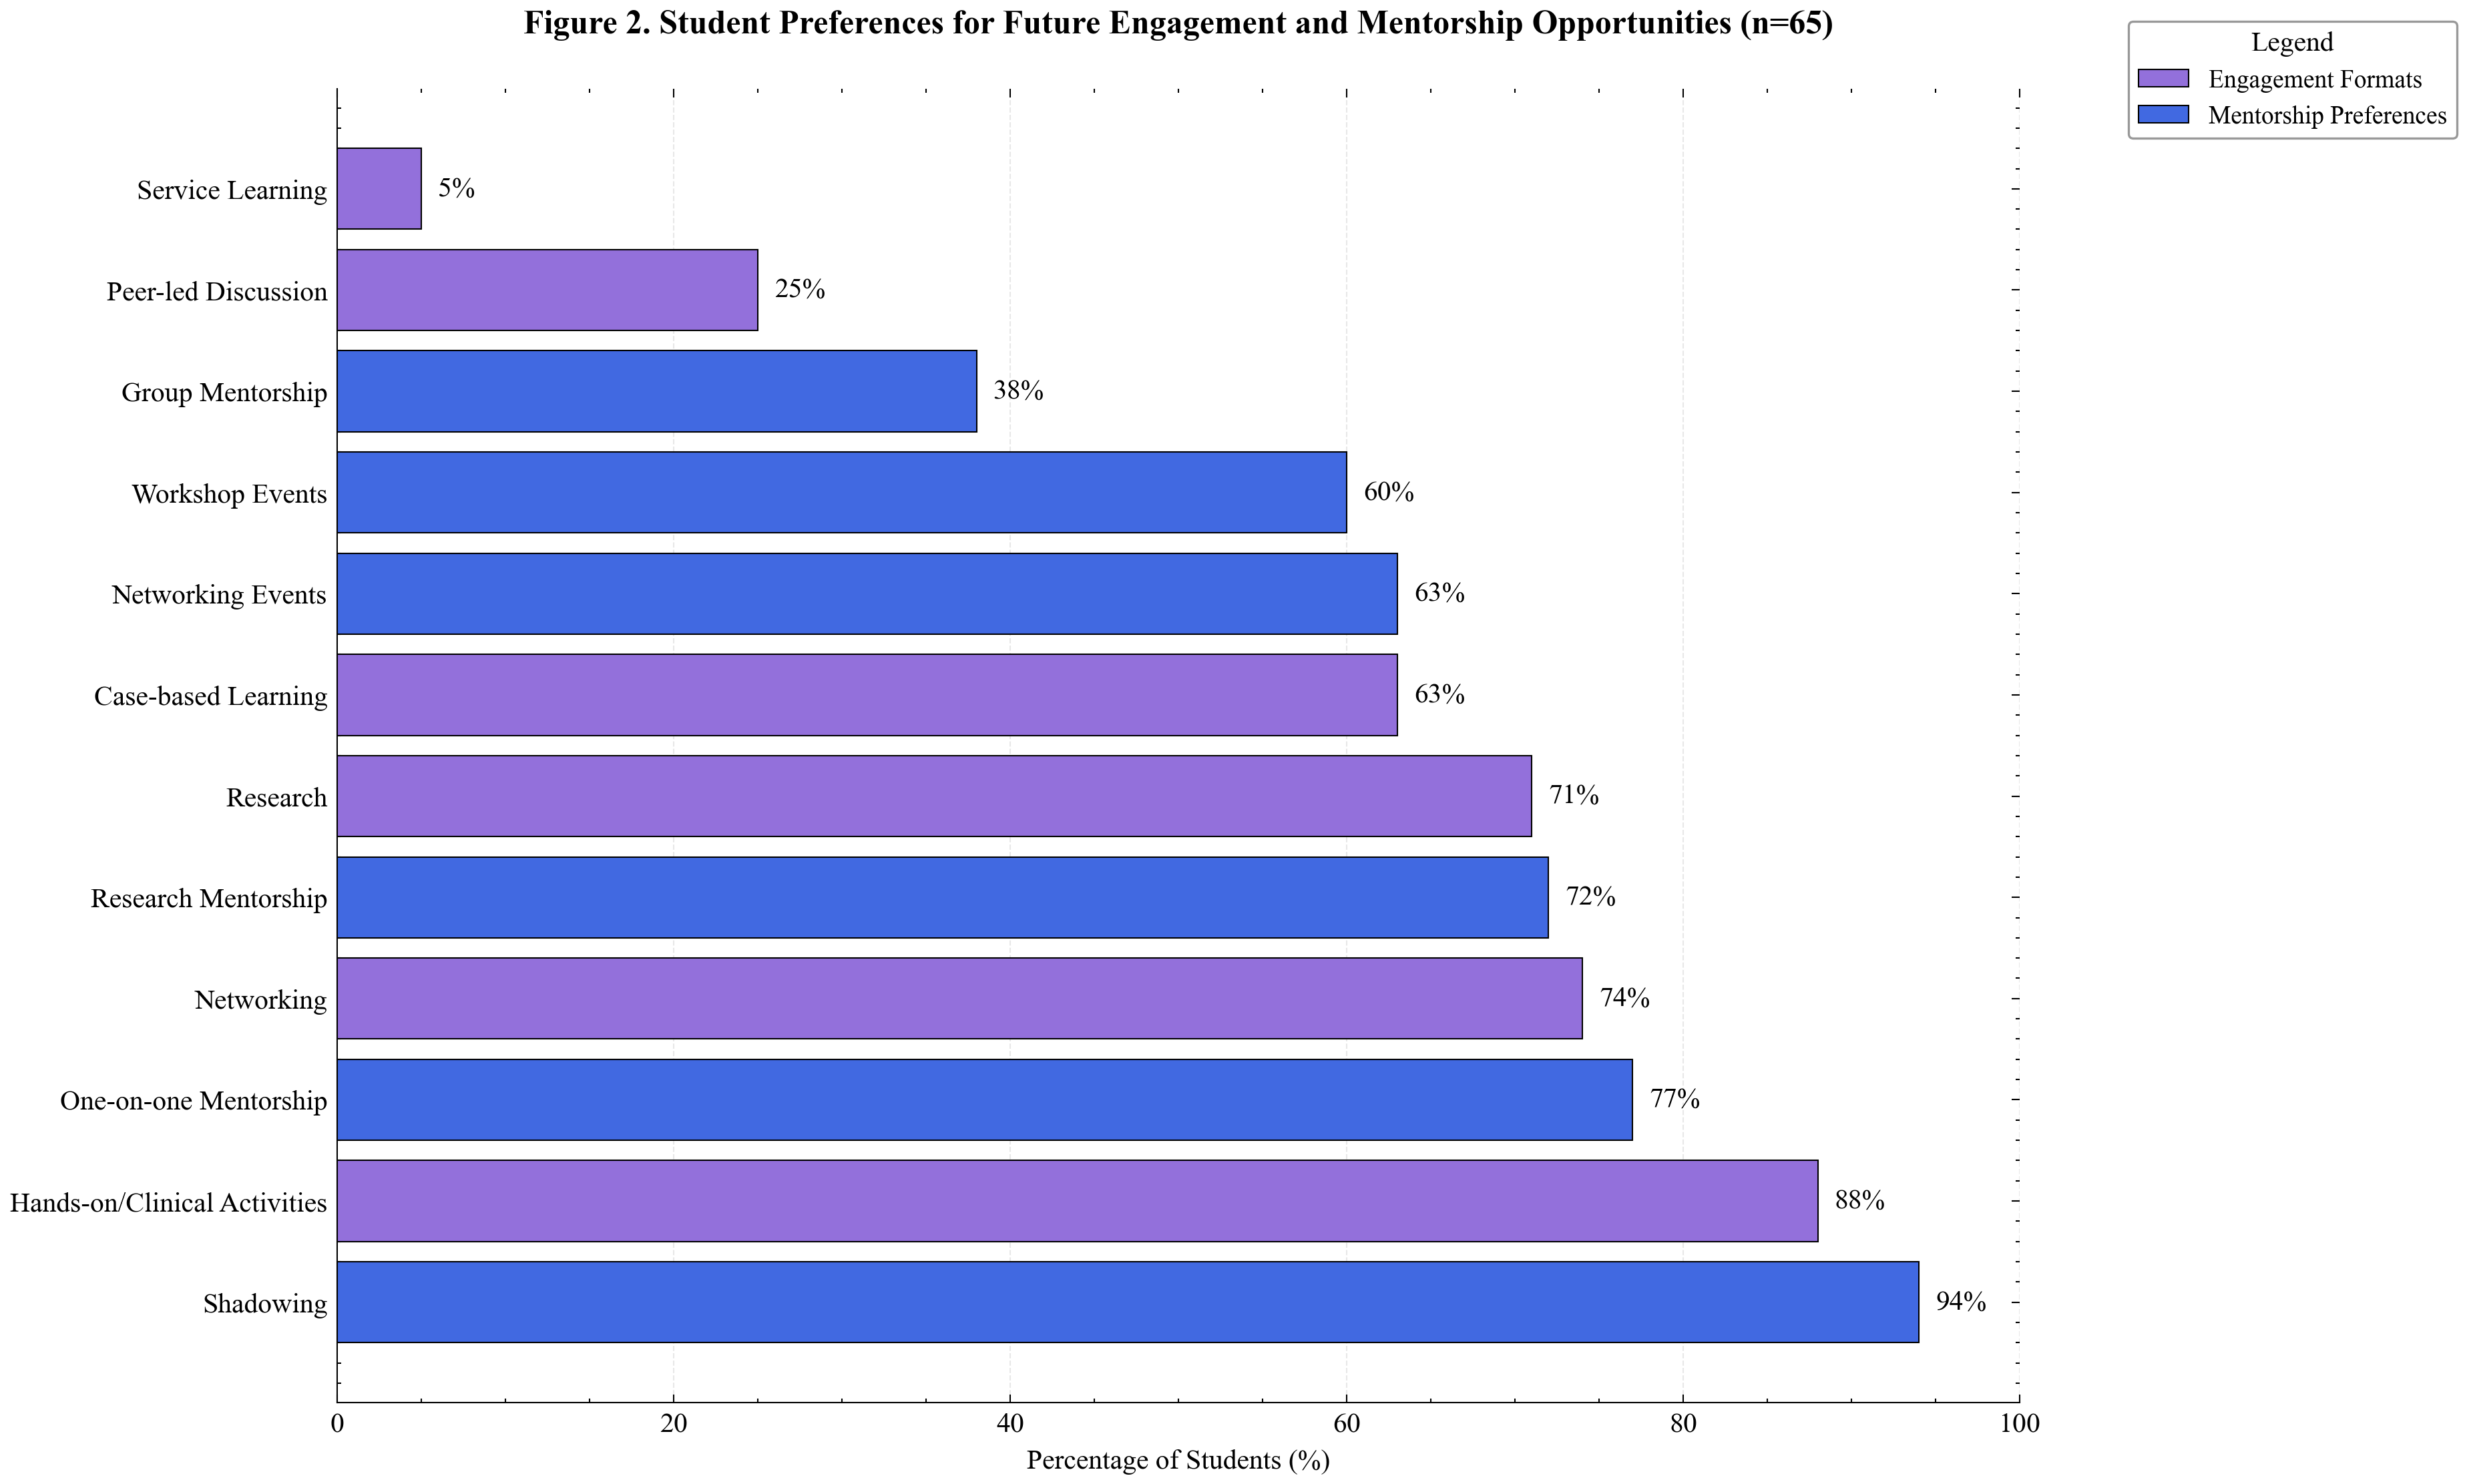

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scienceplots

# Set publication style
plt.style.use(['science', 'no-latex', 'bright'])
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300
})

# Define engagement data
engagement_data = {
    "Hands-on/Clinical Activities": 57,
    "Networking": 48,
    "Research": 46,
    "Case-based Learning": 41,
    "Peer-led Discussion": 16,
    "Service Learning": 3
}

# Define mentorship data
mentorship_data = {
    "Shadowing": 61,
    "One-on-one Mentorship": 50,
    "Research Mentorship": 47,
    "Networking Events": 41,
    "Workshop Events": 39,
    "Group Mentorship": 25
}

# Combine data into single DataFrame
combined_data = []

# Add engagement data
for method, count in engagement_data.items():
    combined_data.append({
        "Category": method,
        "Percentage": round((count/65)*100),
        "Type": "Engagement Format"
    })

# Add mentorship data
for format_name, count in mentorship_data.items():
    combined_data.append({
        "Category": format_name,
        "Percentage": round((count/65)*100),
        "Type": "Mentorship Preference"
    })

# Create DataFrame and sort from greatest to least (ascending=False)
# This will put the highest percentages at bottom and lowest at top
combined_df = pd.DataFrame(combined_data)
combined_df = combined_df.sort_values("Percentage", ascending=False)

# Create figure with extra width for external legend
fig, ax = plt.subplots(figsize=(12, 8))

# Create colors list based on type
colors = ['#9370DB' if row['Type'] == 'Engagement Format' else '#4169E1' 
          for _, row in combined_df.iterrows()]

# Create horizontal bar plot
bars = ax.barh(range(len(combined_df)), combined_df['Percentage'], 
               color=colors, edgecolor='black', linewidth=0.5)

# Format plot
ax.set_xlabel("Percentage of Students (%)", fontsize=10)
ax.set_ylabel("", fontsize=10)
ax.set_title("Figure 2. Student Preferences for Future Engagement and Mentorship Opportunities (n=65)", 
             fontsize=12, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=10)
ax.set_xlim(0, 100)

# Set y-axis labels
ax.set_yticks(range(len(combined_df)))
ax.set_yticklabels(combined_df['Category'])

# Add percentage labels
for i, (_, row) in enumerate(combined_df.iterrows()):
    ax.text(row['Percentage'] + 1, i, f"{int(row['Percentage'])}%", 
            va='center', fontsize=10)

# Add grid
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Create legend elements
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#9370DB', edgecolor='black', linewidth=0.5, label='Engagement Formats'),
    Patch(facecolor='#4169E1', edgecolor='black', linewidth=0.5, label='Mentorship Preferences')
]

# Position legend outside the plot area (similar to Figure 1)
legend = fig.legend(handles=legend_elements, 
                   loc='upper left',
                   bbox_to_anchor=(0.82, 0.95),  # Position in the reserved right space
                   fontsize=9,
                   frameon=True,
                   fancybox=True,
                   shadow=False,
                   title='Legend',
                   title_fontsize=10)

# Style legend frame to match Figure 1
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(0.8)

# Remove spines
sns.despine()

# Adjust layout to create space for external legend (similar to Figure 1)
plt.subplots_adjust(
    left=0.08,
    right=0.78,  # Squeeze plot to the left, creating space for legend
    top=0.90,    # Create space for title
    bottom=0.08  # Space at bottom
)

# Save figure in manuscript folder
plt.savefig("Manuscript/Fig2_combined_preferences_single_plot.png", dpi=300, bbox_inches="tight")
plt.show()